Imports and final vars declaration

In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from common.parser_utils import ParserUtils
from common.data_frame_utils import DataFrameUtils
from common.data_visualization import DataVisualization
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector, BatchNormalization, LeakyReLU, Dropout
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import confusion_matrix

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# rcParams['figure.figsize'] = 11, 5

# RANDOM_SEED = 3

# np.random.seed(RANDOM_SEED)
# tf.random.set_seed(RANDOM_SEED)


Obtain data

In [2]:
full_df = ParserUtils.get_full_dataframe_without_error_previous_data(None, None, None, 4000)

train_df, test_df = DataFrameUtils.train_test_split(full_df, 0.2)

# Check if test_df or train_df have anormal data
print(test_df['Estado'].unique())
print(train_df['Estado'].unique())


[1 2]
[1]


Process data - Normalization

In [3]:
test_ok = DataFrameUtils.get_test_ok_dataframe_as_preprocessed_np_array(test_df)
test_error = DataFrameUtils.get_test_error_dataframe_as_preprocessed_np_array(test_df)
train = DataFrameUtils.get_train_dataframe_as_preprocessed_np_array(train_df)
test, test_state = DataFrameUtils.get_test_mixed_dataframe_as_preprocessed_np_array(test_df)

Process data - Temporalize

In [4]:
timesteps = 6
n_features = 12

X, y = DataFrameUtils.temporalize(X = train, y = np.zeros(len(train)), lookback = timesteps)

train = np.array(X)
train = train.reshape(train.shape[0], timesteps, n_features)

X, y = DataFrameUtils.temporalize(X = test_ok, y = np.zeros(len(test_ok)), lookback = timesteps)

test_ok = np.array(X)
test_ok = test_ok.reshape(test_ok.shape[0], timesteps, n_features)


X, y = DataFrameUtils.temporalize(X = test_error, y = np.zeros(len(test_error)), lookback = timesteps)

test_error = np.array(X)
test_error = test_error.reshape(test_error.shape[0], timesteps, n_features)

X, y = DataFrameUtils.temporalize(X = test, y = np.zeros(len(test)), lookback = timesteps)

test = np.array(X)
test = test.reshape(test.shape[0], timesteps, n_features)

print(train.shape)
print(test_ok.shape)
print(test_error.shape)
print(test.shape)

(157261, 6, 12)
(39299, 6, 12)
(1047, 6, 12)
(40353, 6, 12)


Autoencoder architecture

In [5]:
# Convert array to temporalized array
input_dim = (timesteps, n_features)
input_obj = Input(shape=input_dim)
print(input_obj)

# Autoencoder creation
# Enconder level 1
e = LSTM(units=int(48), return_sequences=True) (input_obj)
e = LeakyReLU()(e)
e = BatchNormalization()(e)
# Enconder level 2
e = LSTM(units=int(36), return_sequences=True) (e)
e = LeakyReLU()(e)
e = BatchNormalization()(e)
# Enconder level 3
e = LSTM(units=int(24), return_sequences=True) (e)
e = LeakyReLU()(e)
e = Dropout(0.1)(e)
# Encoder level 4
e = LSTM(units=int(18), return_sequences=True) (e)
e = LeakyReLU()(e)
e = BatchNormalization()(e)
# Encoder level 5
e = LSTM(units=int(12), return_sequences=True) (e)
e = LeakyReLU()(e)
e = BatchNormalization()(e)
# Encoder level 6
e = LSTM(units=int(8), return_sequences=True) (e)
e = LeakyReLU()(e)
e = Dropout(0.1)(e)

# Bottle Neck
bottleneck = LSTM(units=6, return_sequences=False) (e)
bottleneck = RepeatVector(timesteps)(bottleneck)

# Decoder level 1
d = LSTM(units=int(8), return_sequences=True) (bottleneck)
d = LeakyReLU()(d)
d = BatchNormalization()(d)
# Decoder level 2
d = LSTM(units=int(12), return_sequences=True) (d)
d = LeakyReLU()(d)
d = BatchNormalization()(d)
# Decoder level 3
d = LSTM(units=int(18), return_sequences=True) (d)
d = LeakyReLU()(d)
d = Dropout(0.1)(d)
# Decoder level 4
d = LSTM(units=int(24), return_sequences=True) (d)
d = LeakyReLU()(d)
d = BatchNormalization()(d)
# Decoder level 5
d = LSTM(units=int(36), return_sequences=True) (d)
d = LeakyReLU()(d)
d = BatchNormalization()(d)
# Decoder level 6
d = LSTM(units=int(48), return_sequences=True) (d)
d = LeakyReLU()(d)
d = Dropout(0.1)(d)

# Sigmoid retorna valors de 0 a 1, igual que els valors que hem posat dentrada
output = TimeDistributed(Dense(units=int(n_features), activation='sigmoid'))(d)

# Autoencoder
autoencoder = Model(inputs=input_obj, outputs=output)

autoencoder.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 12), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 12)]           0         
                                                                 
 lstm (LSTM)                 (None, 6, 48)             11712     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6, 48)             0         
                                                                 
 batch_normalization (BatchN  (None, 6, 48)            192       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 6, 36)             12240     
                                              

Autoencoder training

In [6]:
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    train,
    train,
    epochs=40,
    batch_size=500,
    validation_data=(test_ok, test_ok),
    shuffle=False
)

Epoch 1/40
315/315 [==============================] - 22s 29ms/step - loss: 0.0393 - val_loss: 0.1470
Epoch 2/40
315/315 [==============================] - 7s 21ms/step - loss: 0.0071 - val_loss: 0.0110
Epoch 3/40
315/315 [==============================] - 7s 21ms/step - loss: 0.0047 - val_loss: 0.0062
Epoch 4/40
315/315 [==============================] - 7s 22ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 5/40
315/315 [==============================] - 7s 22ms/step - loss: 0.0053 - val_loss: 0.0090
Epoch 6/40
315/315 [==============================] - 7s 22ms/step - loss: 0.0041 - val_loss: 0.0055
Epoch 7/40
315/315 [==============================] - 7s 23ms/step - loss: 0.0035 - val_loss: 0.0055
Epoch 8/40
315/315 [==============================] - 7s 21ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 9/40
315/315 [==============================] - 7s 21ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 10/40
315/315 [==============================] - 6s 21ms/step - loss: 0.0029 - val_l

Autoencoder validation

Graph showing loss through training - should be 0


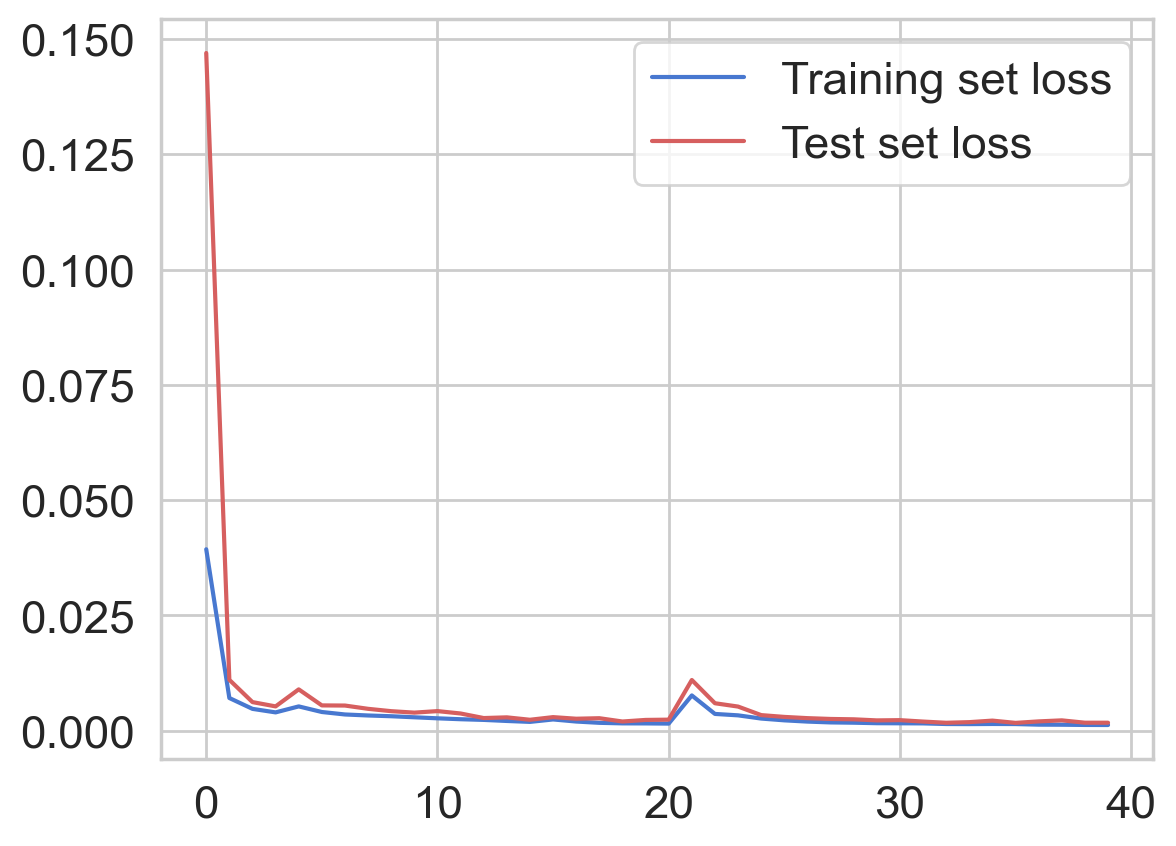

In [7]:
DataVisualization.training_test_loss(history)


Graph representation of normal data and anormal data


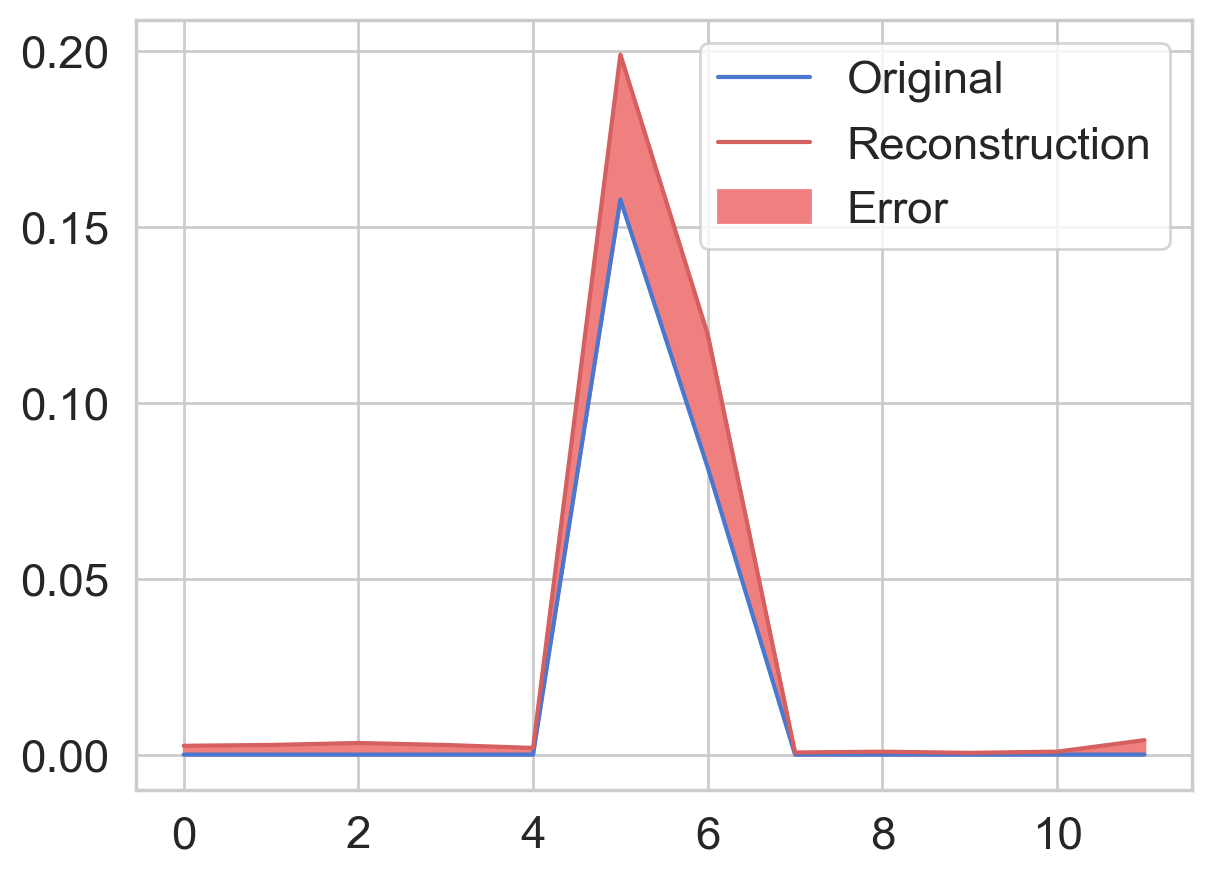

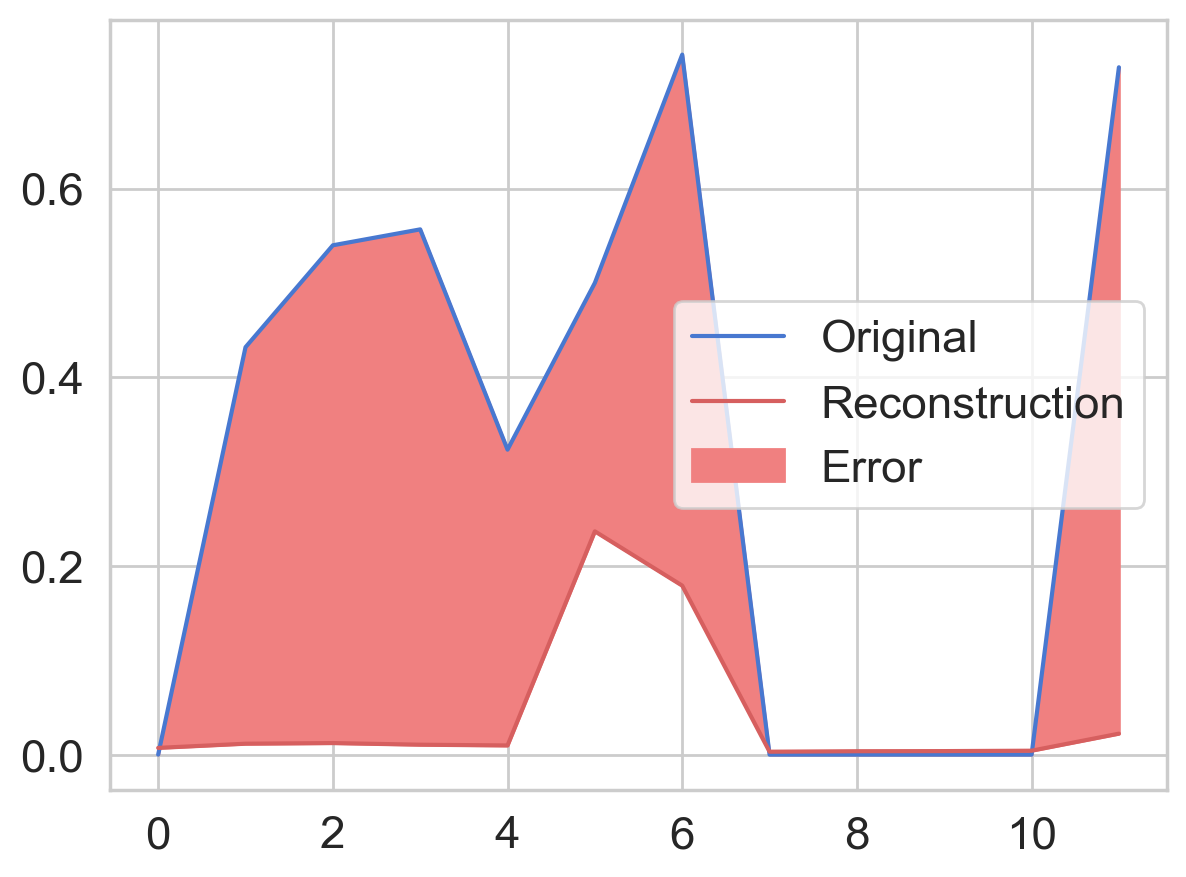

In [8]:
test_ok_pred = autoencoder(test_ok).numpy()
test_error_pred = autoencoder(test_error).numpy()

test_ok_detemp = DataFrameUtils.detemporalize(test_ok)
test_ok_pred_detemp = DataFrameUtils.detemporalize(test_ok_pred)

test_error_detemp = DataFrameUtils.detemporalize(test_error)
test_error_pred_detemp = DataFrameUtils.detemporalize(test_error_pred)

sample_position = 12

DataVisualization.data_reconstruction(test_ok_detemp, test_ok_pred_detemp, sample_position, test_ok_detemp.shape[1])

DataVisualization.data_reconstruction(test_error_detemp, test_error_pred_detemp, sample_position, test_error_detemp.shape[1])

Threshold


In [9]:
test_pred = autoencoder(test).numpy()

test_detemp = DataFrameUtils.detemporalize(test)
test_pred_detemp = DataFrameUtils.detemporalize(test_pred)

loss = tf.keras.losses.mse(test_pred_detemp, test_detemp)

threshold = np.mean(loss) + np.std(loss)
print("Threshold: ", threshold)

Threshold:  0.009056042655605225


Confusion matrix





In [10]:
test_pred = autoencoder.predict(test)

test_detemp = DataFrameUtils.detemporalize(test)
test_pred_detemp = DataFrameUtils.detemporalize(test_pred)

test_state = test_state[timesteps+1:]

mse = np.mean(np.power(test_detemp - test_pred_detemp, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
'True_class': test_state})
error_df.describe()

1262/1262 [==============================] - 9s 6ms/step


,Reconstruction_error
count,40353.000000
mean,0.002142
std,0.006915
min,0.000005
25%,0.000192
50%,0.000539
75%,0.001691
max,0.435659


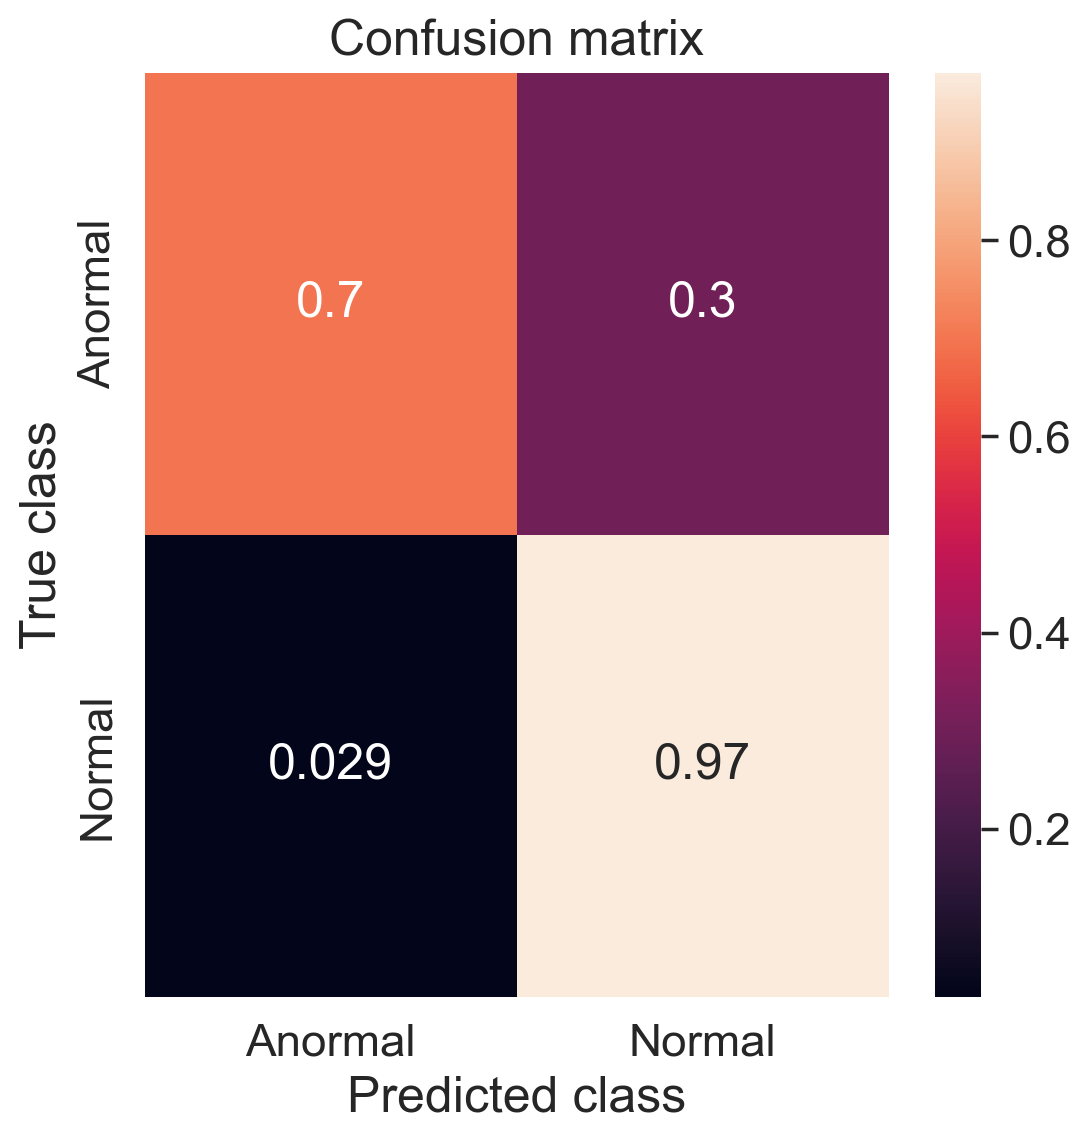

In [11]:

LABELS = ['Anormal', 'Normal']

pred_state = [0 if e > threshold else 1 for e in error_df.Reconstruction_error.values]
test_state_formatted = [1 if e == 1 else 0 for e in error_df.True_class.values]

result = confusion_matrix(test_state_formatted, pred_state , normalize='true')

plt.figure(figsize=(6, 6))
sns.heatmap(result, xticklabels=LABELS, yticklabels=LABELS, annot=True);
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


Graph nº samples / losses

33/33 [==============================] - 0s 6ms/step


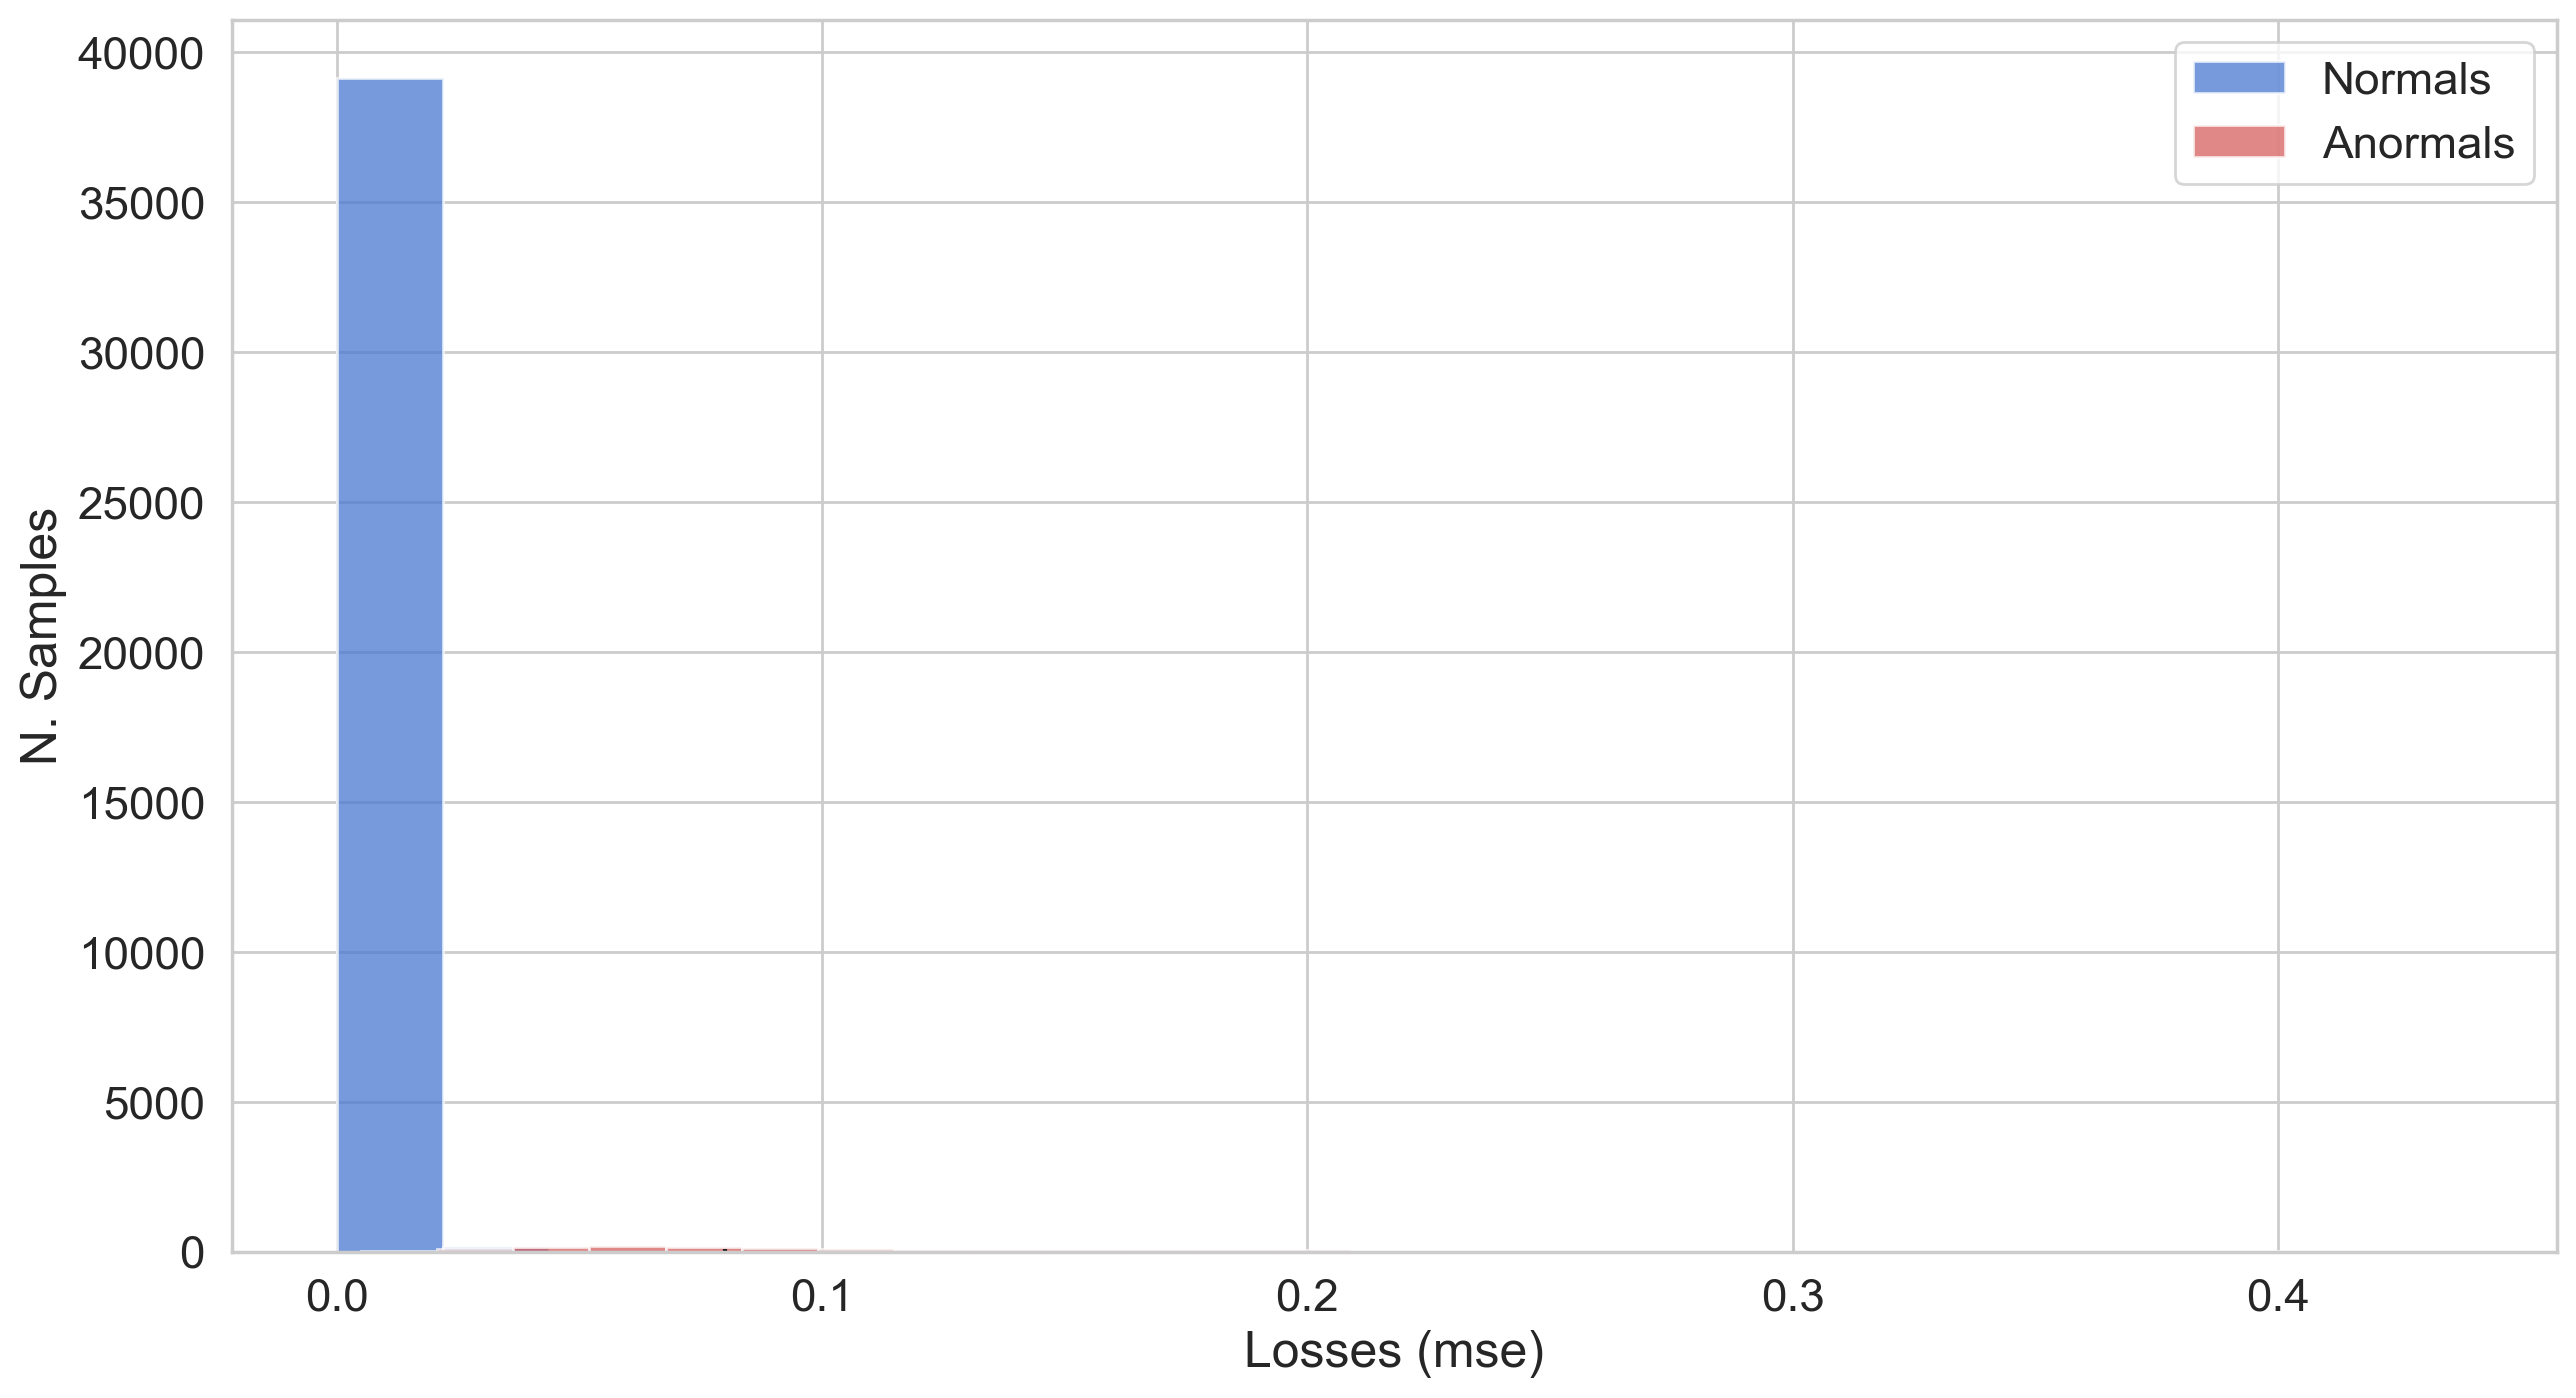

In [12]:
pred_ok = autoencoder.predict(test_ok)
pred_error = autoencoder.predict(test_error)

test_ok_detemp = DataFrameUtils.detemporalize(test_ok)
pred_ok_detemp = DataFrameUtils.detemporalize(pred_ok)

test_error_detemp = DataFrameUtils.detemporalize(test_error)
pred_error_detemp = DataFrameUtils.detemporalize(pred_error)

# Error medio entre reconstruccion y datos reales
loss_ok = tf.keras.losses.mse(pred_ok_detemp, test_ok_detemp)
loss_error = tf.keras.losses.mse(pred_error_detemp, test_error_detemp)

plt.figure(figsize=(15,8))
plt.hist(loss_ok[None,:], bins=20, alpha=0.75, label='Normals')
plt.hist(loss_error[None,:], bins=20, alpha=0.75, color='r', label='Anormals')
plt.xlabel('Losses (mse)')
plt.ylabel('N. Samples')
plt.legend(loc='upper right')
plt.vlines(0.08,0,70,'k')

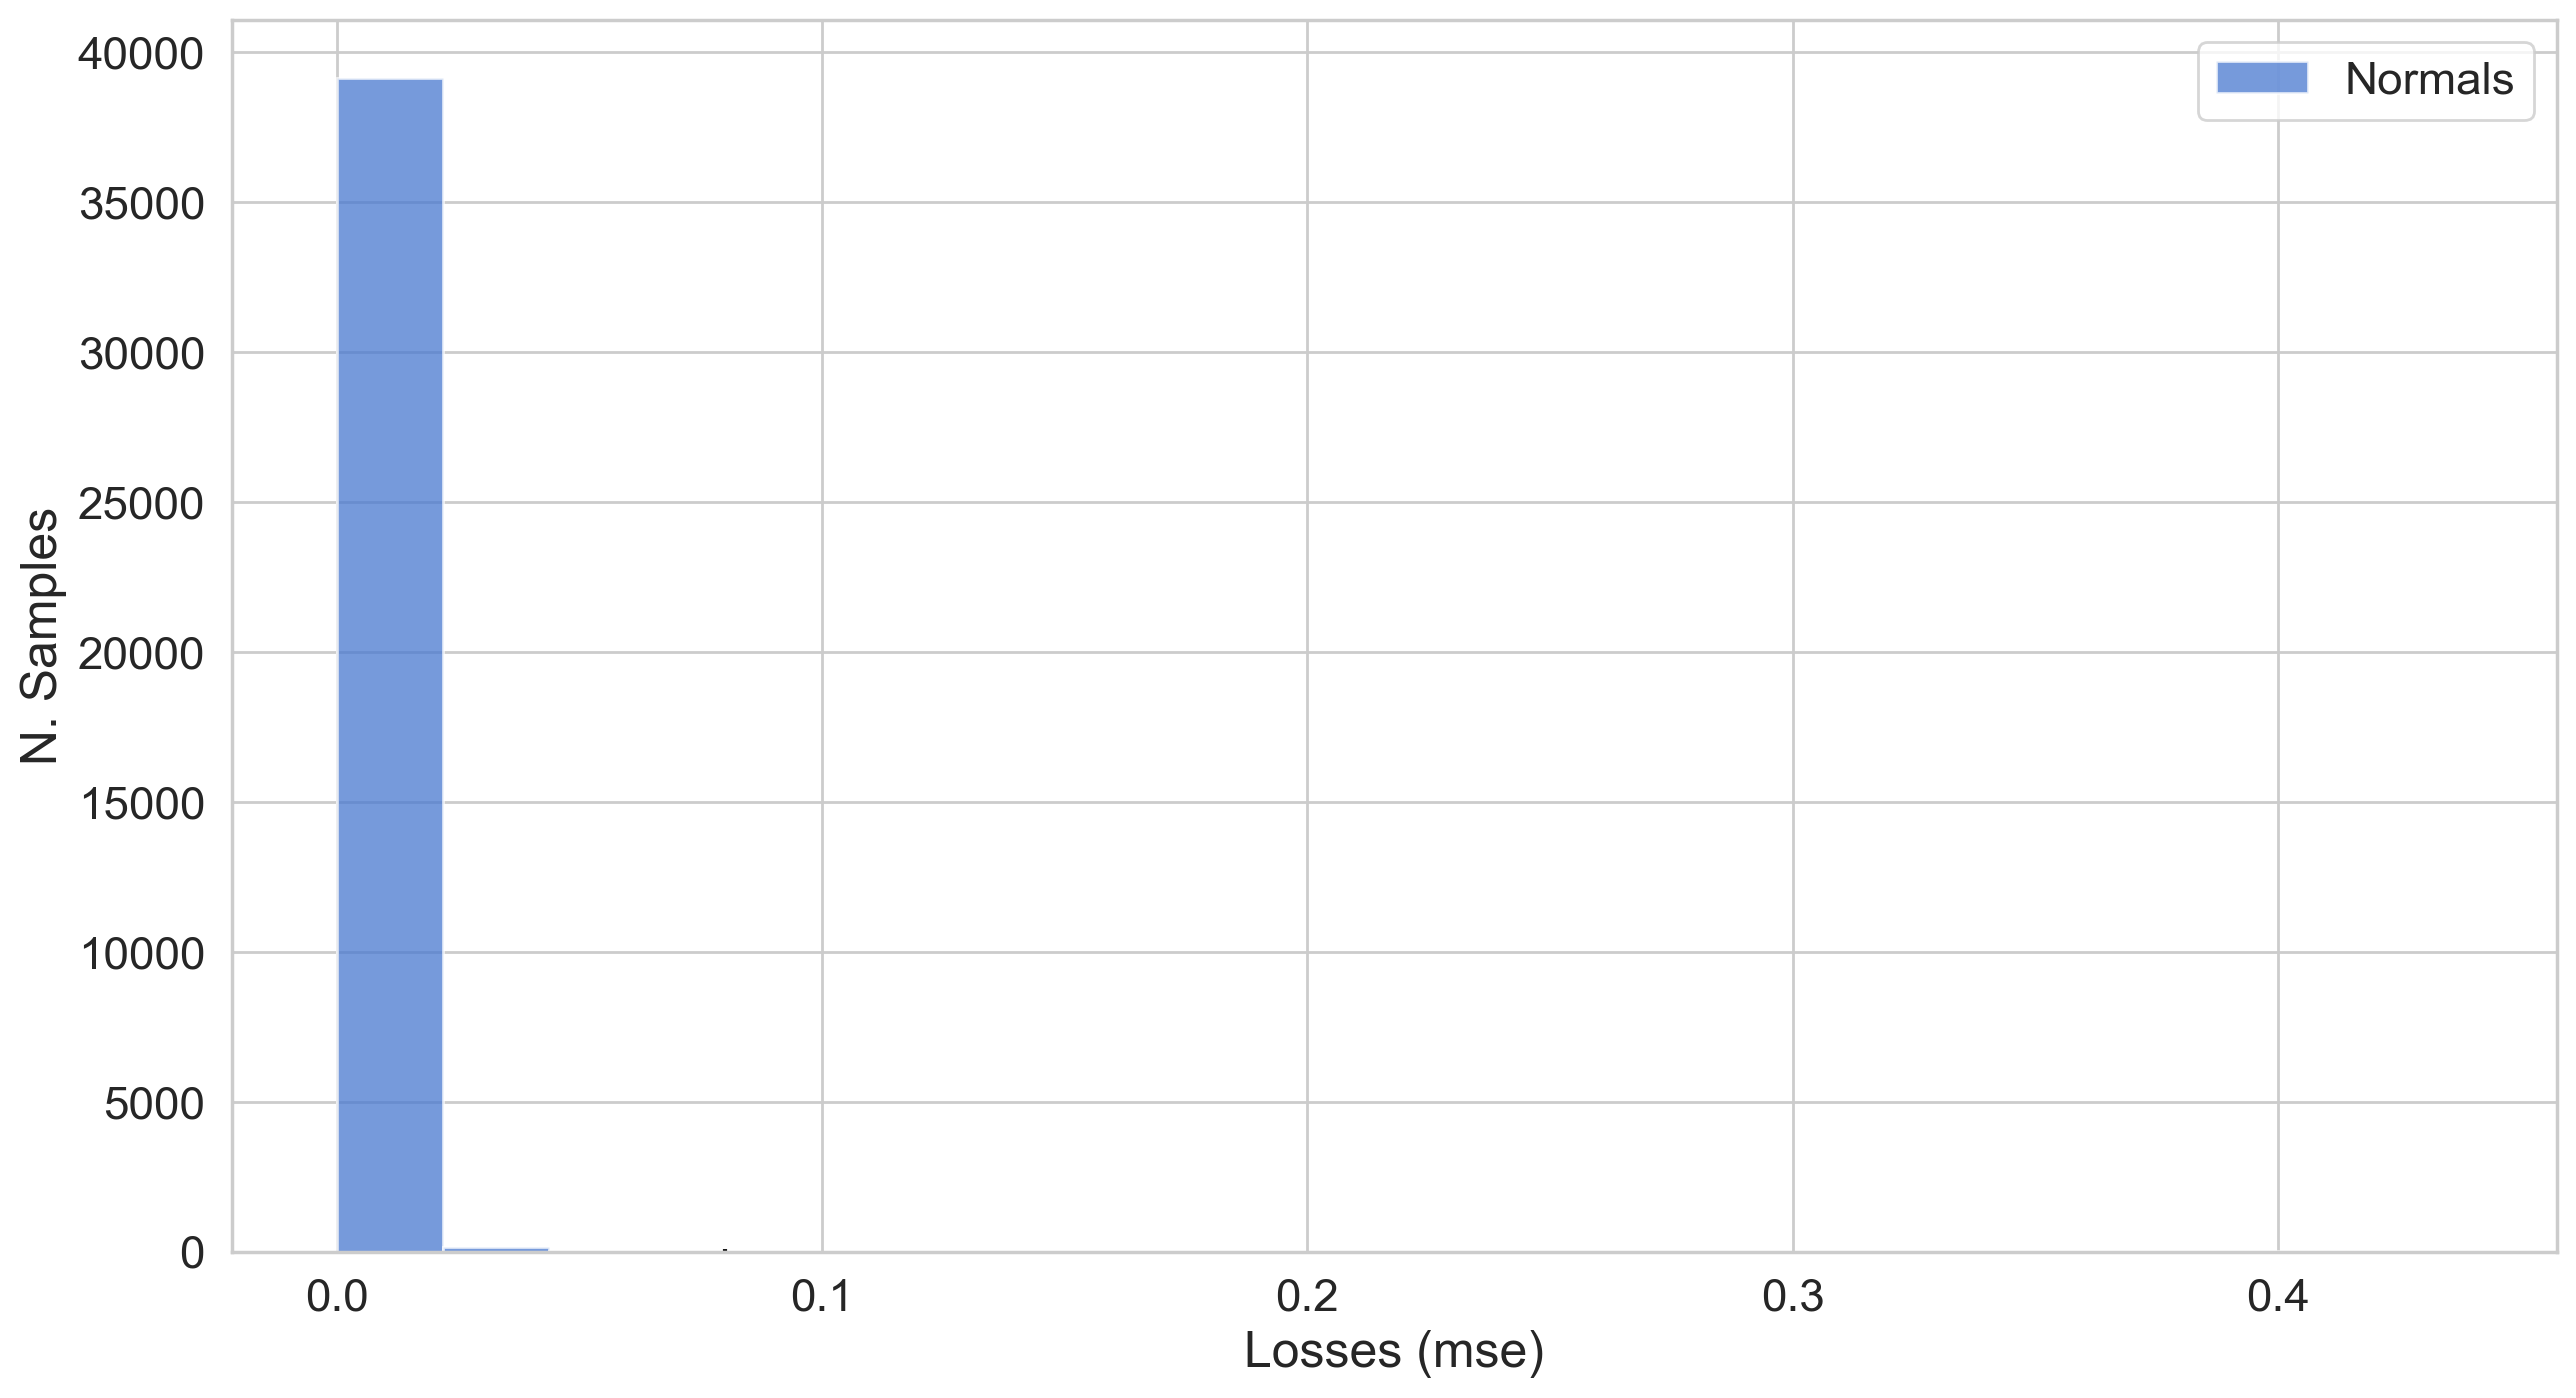

In [13]:
plt.figure(figsize=(15,8))
plt.hist(loss_ok[None,:], bins=20, alpha=0.75, label='Normals')
plt.xlabel('Losses (mse)')
plt.ylabel('N. Samples')
plt.legend(loc='upper right')
plt.vlines(0.08,0,70,'k')

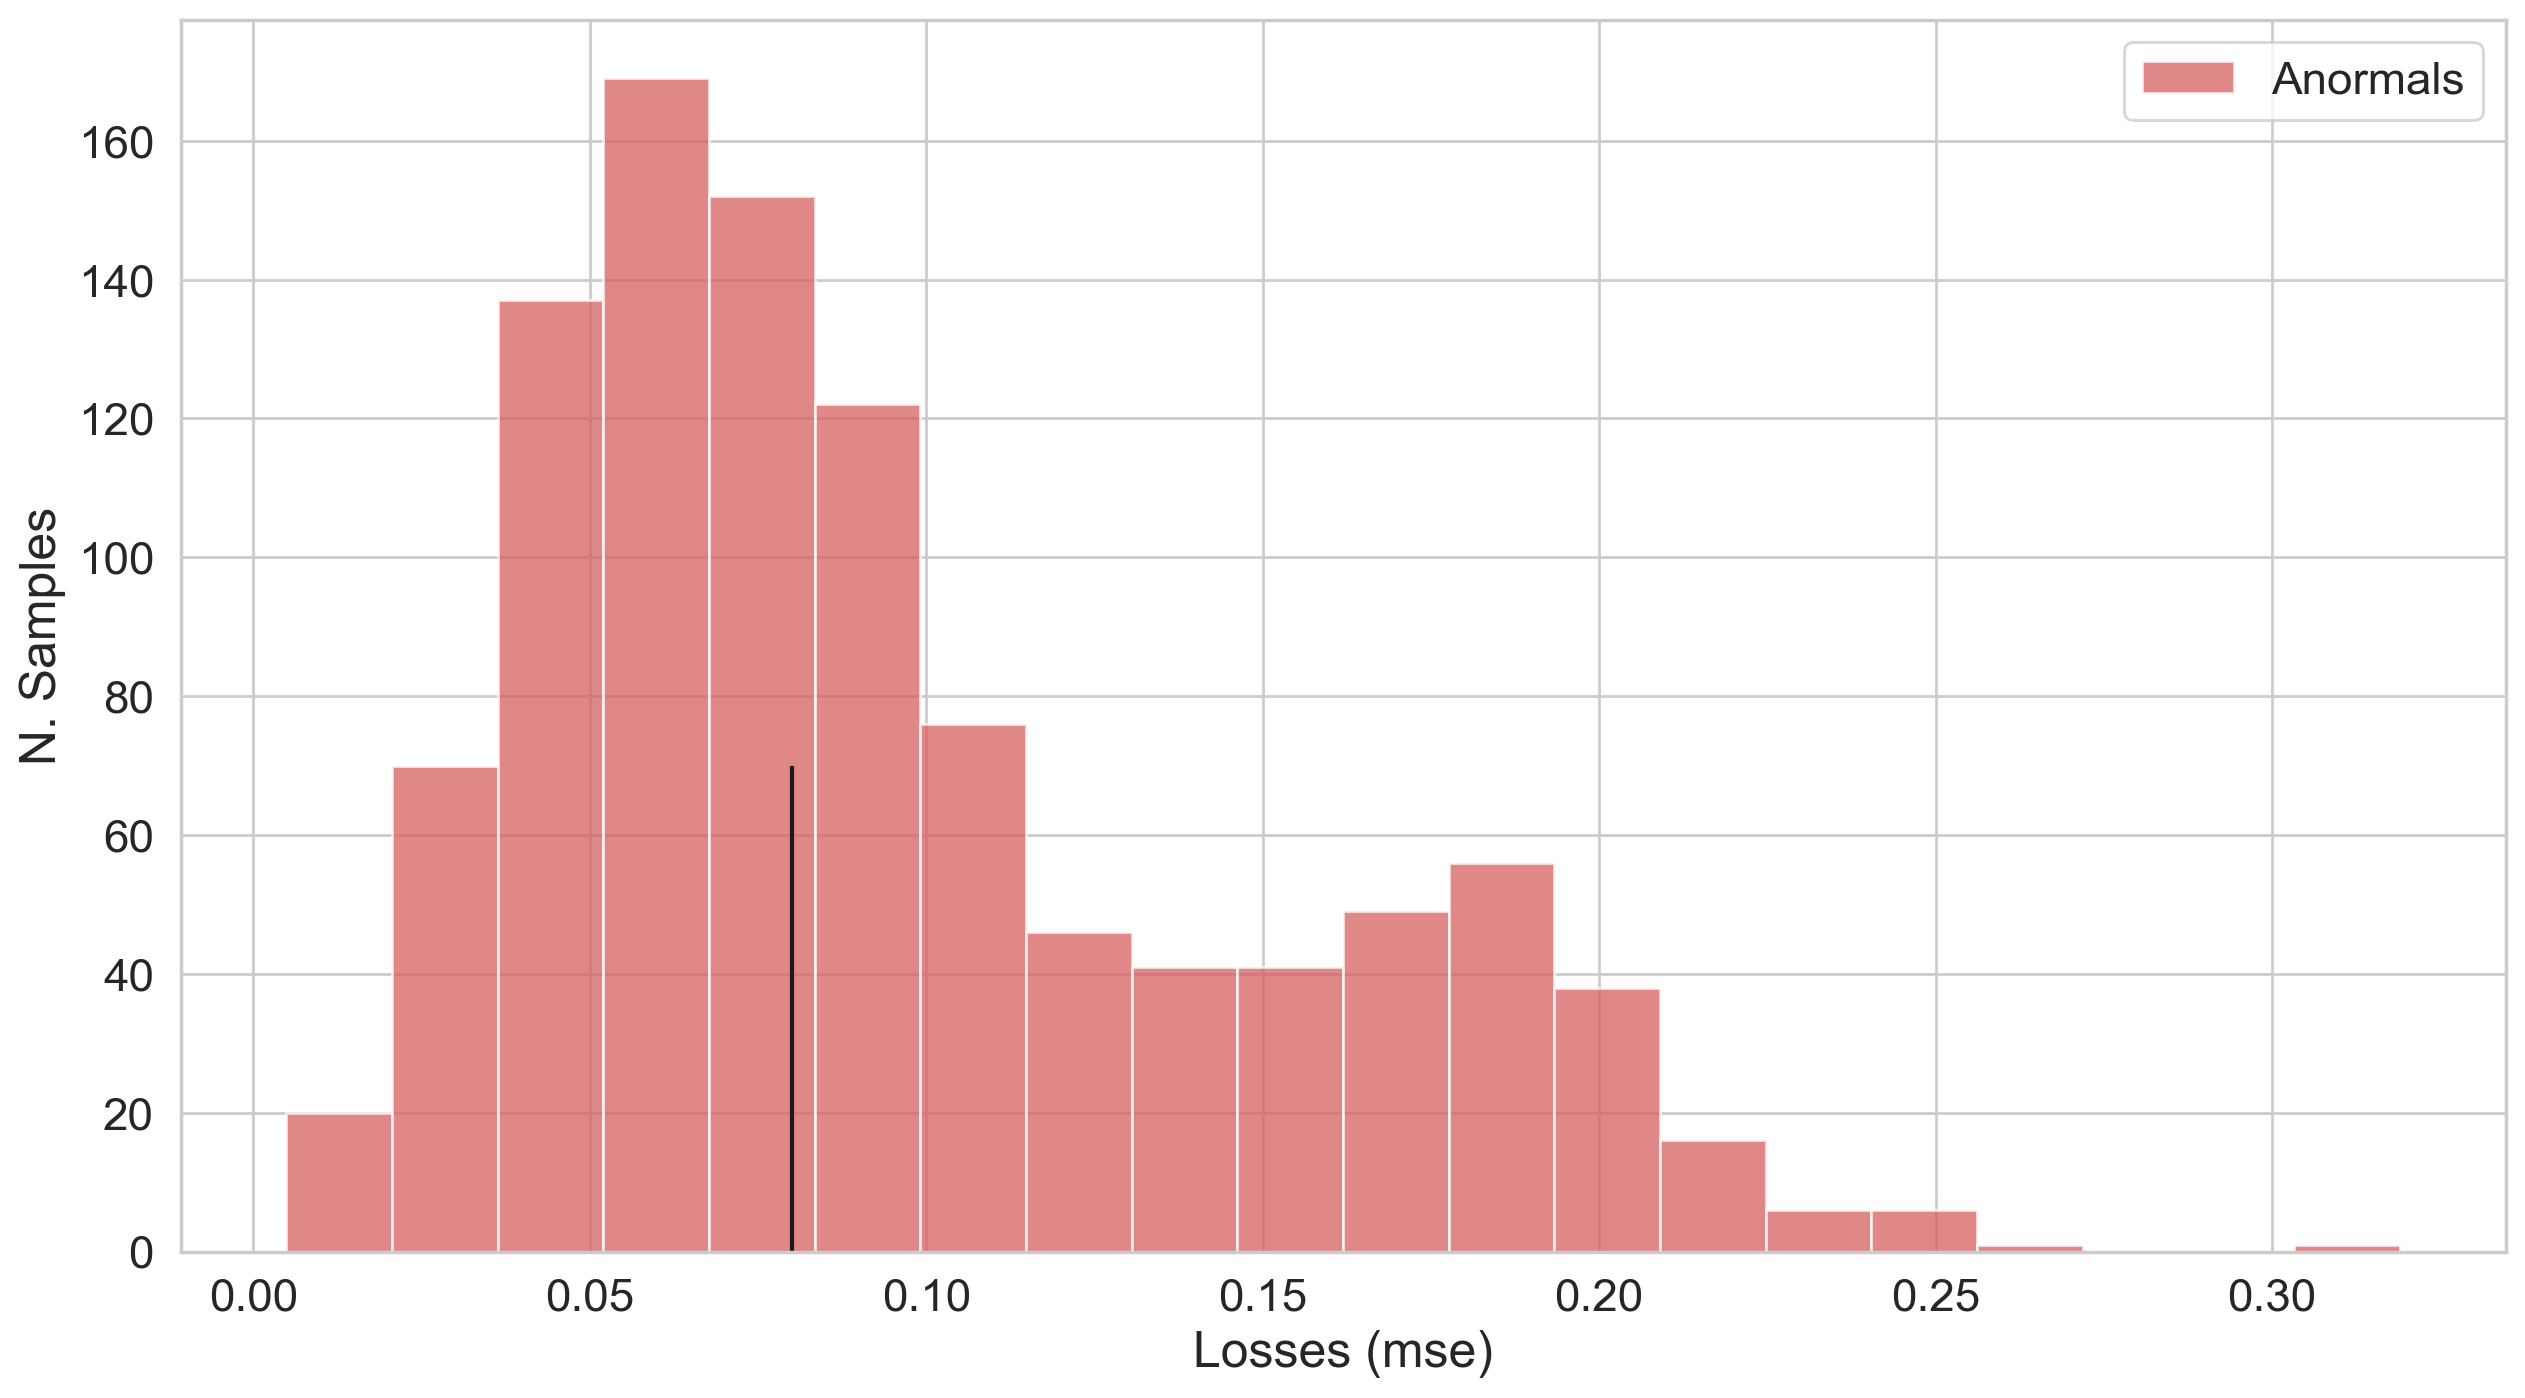

In [14]:
plt.figure(figsize=(15,8))
plt.hist(loss_error[None,:], bins=20, alpha=0.75, color='r', label='Anormals')
plt.xlabel('Losses (mse)')
plt.ylabel('N. Samples')
plt.legend(loc='upper right')
plt.vlines(0.08,0,70,'k')

Graph showing data reproduction and anormal data marked using threshold

Inversor 1 - 15/05/2021 (12786 - 13025)

(33066, 12)
(33059,)


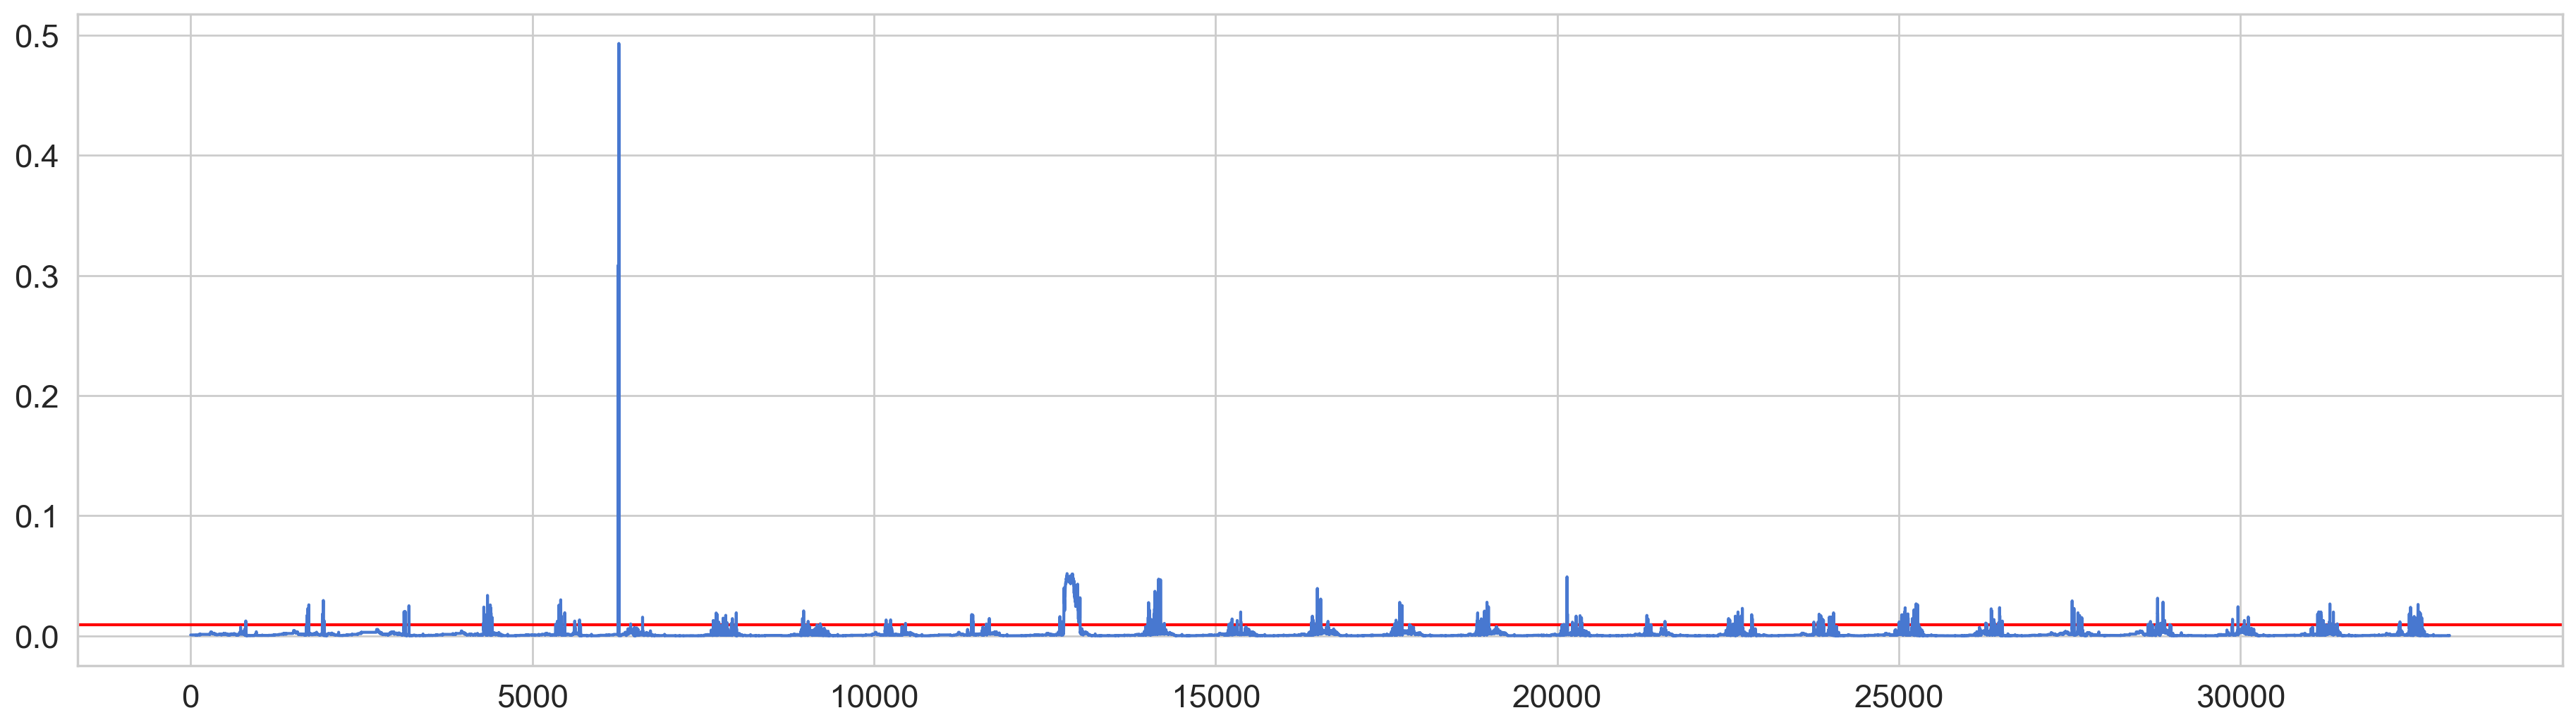

In [15]:
full_df = ParserUtils.get_full_dataframe(1, 5, 2021)

min_max_scaler = MinMaxScaler()

# Obtener por cada valor de labeled data, SIN EL ESTADO y ordenado por tiempo de 2021-01 a 2021-06 el error
# Comprobar así si el error aumenta a medida que se acerca un fallo

full_df = DataFrameUtils.change_state_by_identifier(full_df)

full_df.to_csv('main_test.csv')
main_test_df_clean = full_df.drop('Data', axis=1)
main_test_df_clean = main_test_df_clean.drop('Estado', axis=1)
main_test_df_clean = main_test_df_clean.drop('Fecha', axis=1)

main_test_norm = min_max_scaler.fit_transform(main_test_df_clean.values)

print(main_test_norm.shape)

X_main_test_norm, y_main_test_norm = DataFrameUtils.temporalize(X = main_test_norm, y = np.zeros(len(main_test_norm)), lookback = timesteps)

X_main_test_norm_array = np.array(X_main_test_norm)
X_main_test_norm_reshaped = X_main_test_norm_array.reshape(X_main_test_norm_array.shape[0], timesteps, n_features)


# Data set clean, predict and get error
pred_test = autoencoder(X_main_test_norm_reshaped).numpy()

pred_test_back = DataFrameUtils.detemporalize(pred_test)
X_main_test_norm_reshaped_back = DataFrameUtils.detemporalize(X_main_test_norm_reshaped)

losses = tf.keras.losses.mse(pred_test_back, X_main_test_norm_reshaped_back)
print(losses.shape)

plt.figure(figsize=(50,6))
plt.subplot(1,2,1)
plt.axhline(y=threshold, color='red', linestyle='-')
plt.plot(np.arange(losses.shape[0]), losses)


Inversor 7 - 11/03/2021 (12876 - 13219)

(38278, 12)
(38271,)


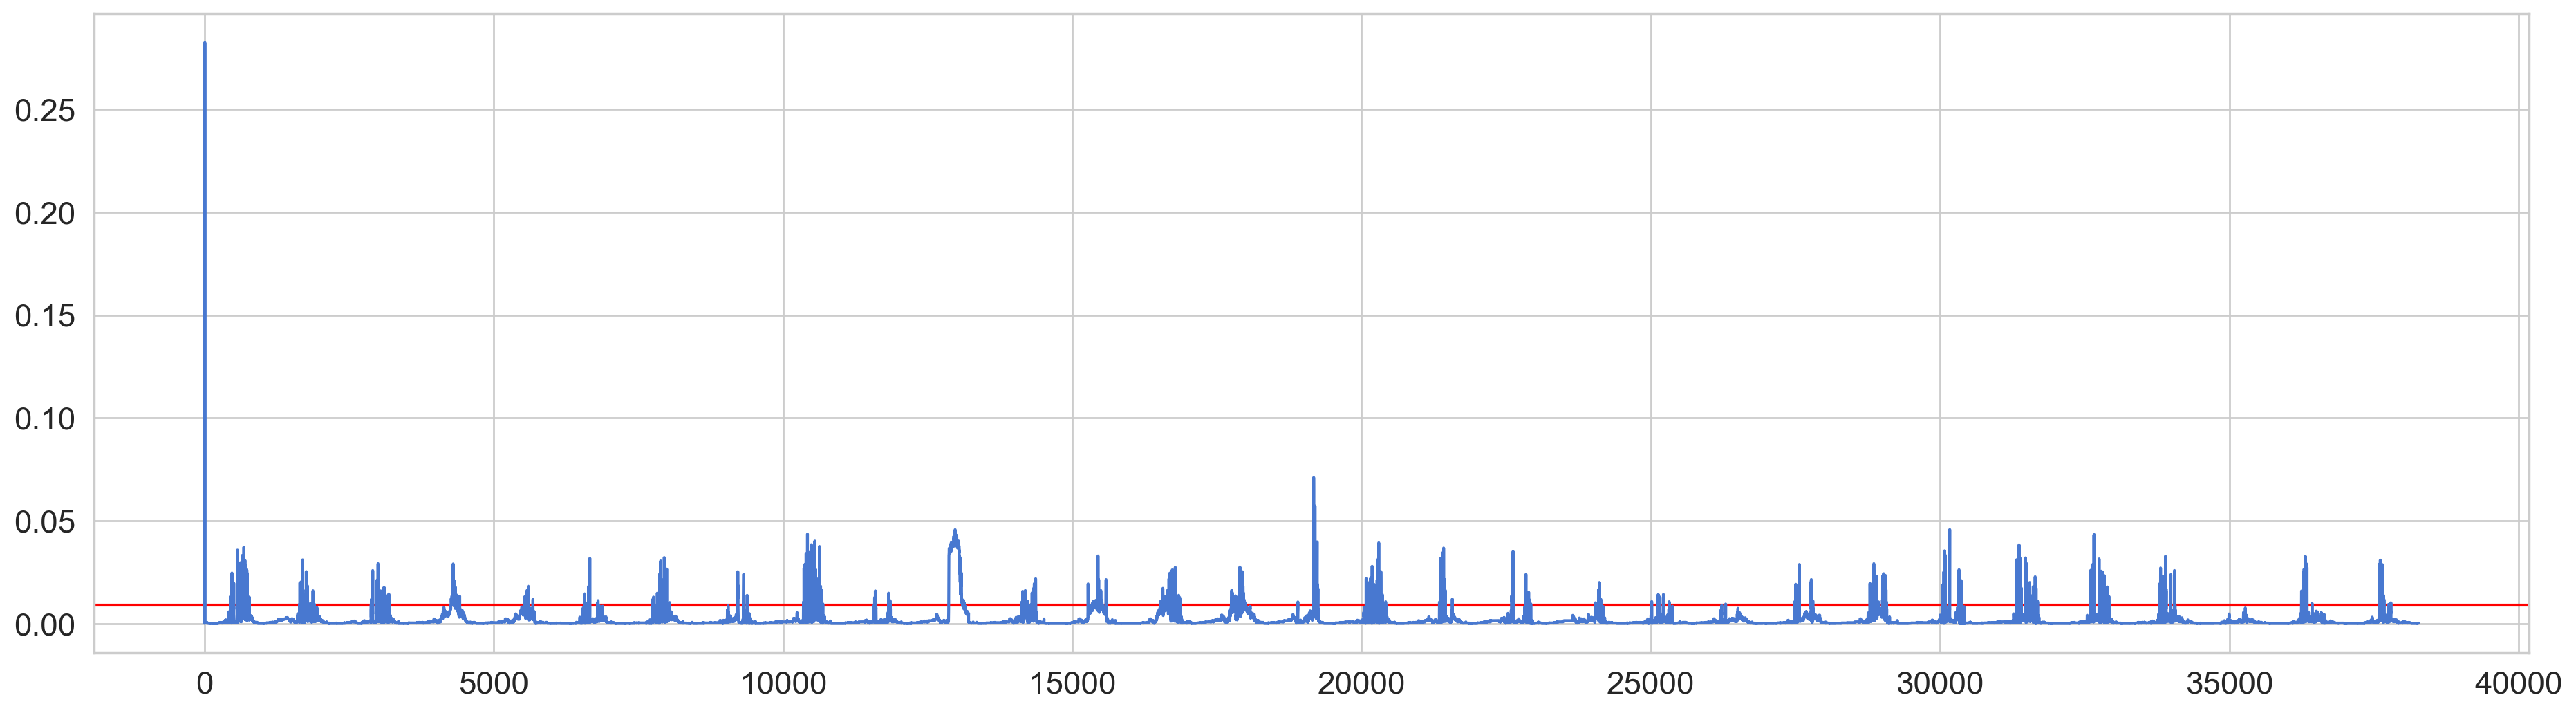

In [16]:
full_df = ParserUtils.get_full_dataframe(7, 3, 2021)

min_max_scaler = MinMaxScaler()

full_df.to_csv('main_test_7_3.csv')
main_test_df_clean = full_df.drop('Data', axis=1)
main_test_df_clean = main_test_df_clean.drop('Fecha', axis=1)
main_test_df_clean = main_test_df_clean.drop('Estado', axis=1)

main_test_norm = min_max_scaler.fit_transform(main_test_df_clean.values)

print(main_test_norm.shape)

X_main_test_norm, y_main_test_norm = DataFrameUtils.temporalize(X = main_test_norm, y = np.zeros(len(main_test_norm)), lookback = timesteps)

X_main_test_norm_array = np.array(X_main_test_norm)
X_main_test_norm_reshaped = X_main_test_norm_array.reshape(X_main_test_norm_array.shape[0], timesteps, n_features)


# Data set clean, predict and get error
pred_test = autoencoder(X_main_test_norm_reshaped).numpy()

pred_test_back = DataFrameUtils.detemporalize(pred_test)
X_main_test_norm_reshaped_back = DataFrameUtils.detemporalize(X_main_test_norm_reshaped)

losses = tf.keras.losses.mse(pred_test_back, X_main_test_norm_reshaped_back)
print(losses.shape)

plt.figure(figsize=(50,6))
plt.subplot(1,2,1)
plt.axhline(y=threshold, color='red', linestyle='-')
plt.plot(np.arange(losses.shape[0]), losses)

Inversor 7 - 17/04/2021 (20592 - 20764)

(37160, 12)
(37153,)


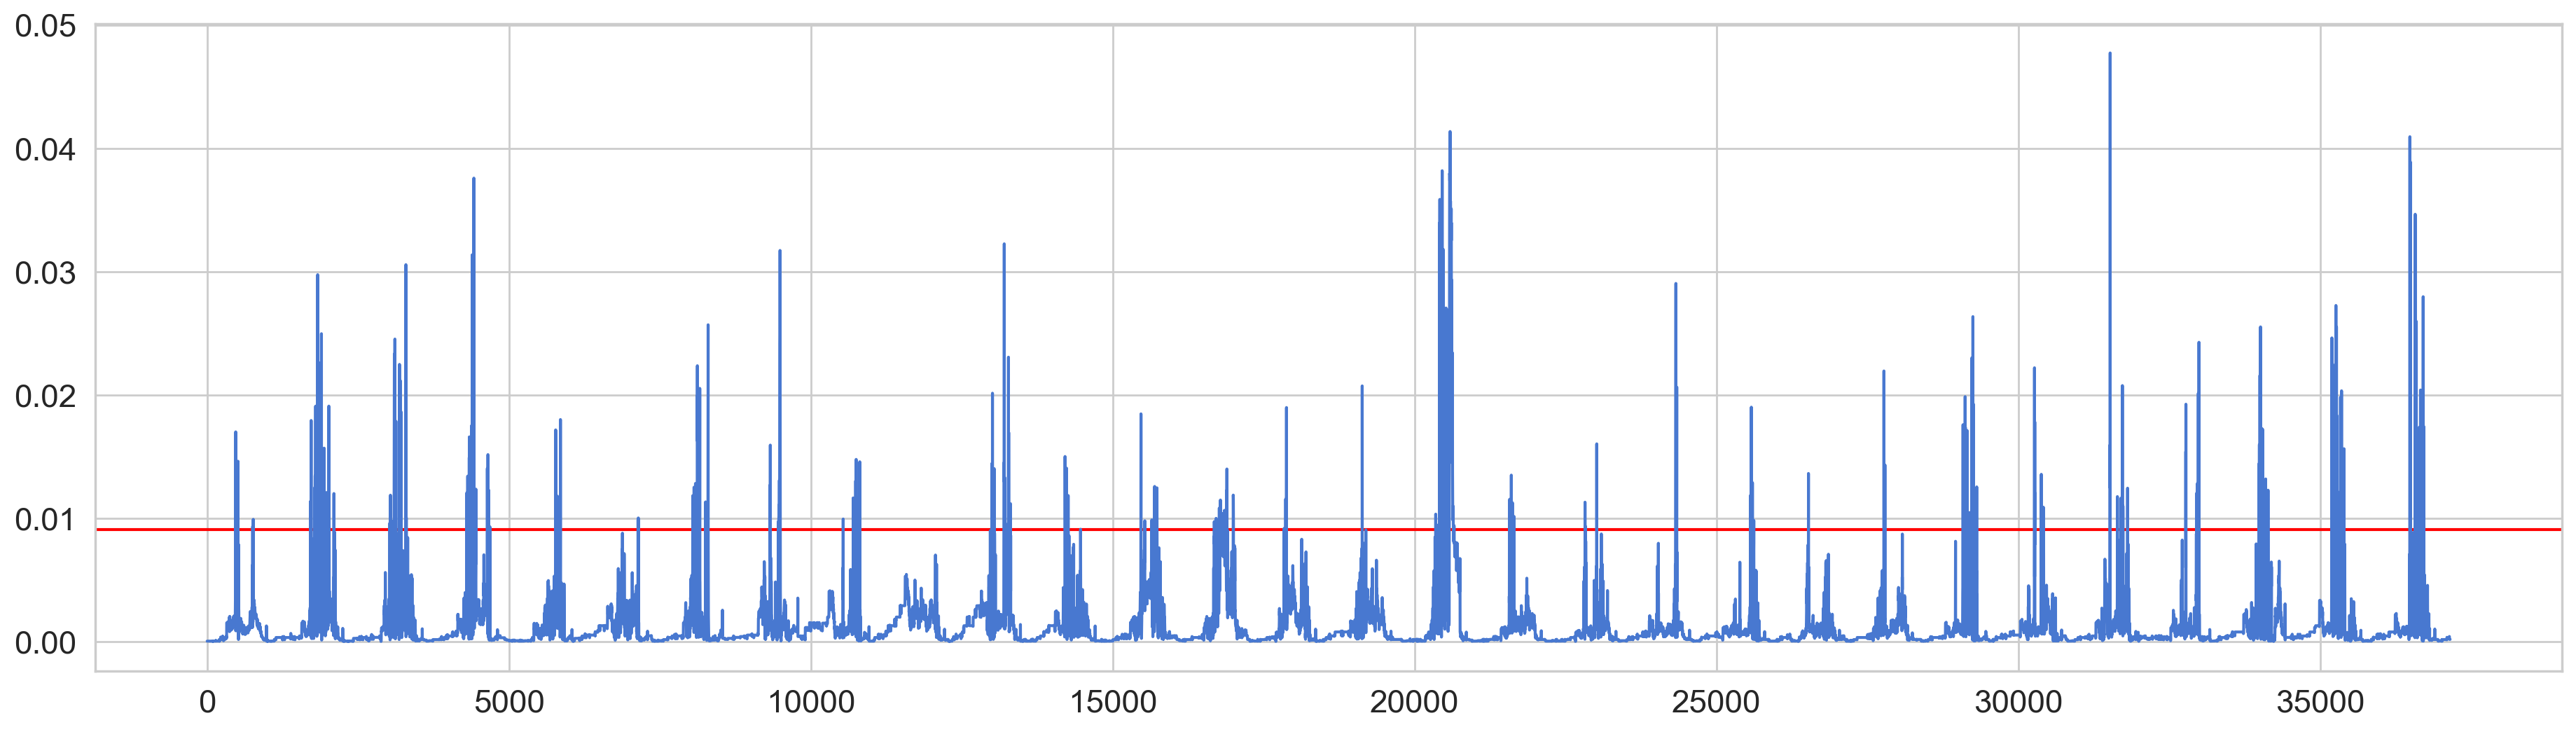

In [17]:
full_df = ParserUtils.get_full_dataframe(7, 4, 2021)

min_max_scaler = MinMaxScaler()

full_df.to_csv('main_test_7_4.csv')
main_test_df_clean = full_df.drop('Data', axis=1)
main_test_df_clean = main_test_df_clean.drop('Fecha', axis=1)
main_test_df_clean = main_test_df_clean.drop('Estado', axis=1)

main_test_norm = min_max_scaler.fit_transform(main_test_df_clean.values)

print(main_test_norm.shape)

X_main_test_norm, y_main_test_norm = DataFrameUtils.temporalize(X = main_test_norm, y = np.zeros(len(main_test_norm)), lookback = timesteps)

X_main_test_norm_array = np.array(X_main_test_norm)
X_main_test_norm_reshaped = X_main_test_norm_array.reshape(X_main_test_norm_array.shape[0], timesteps, n_features)


# Data set clean, predict and get error
pred_test = autoencoder(X_main_test_norm_reshaped).numpy()

pred_test_back = DataFrameUtils.detemporalize(pred_test)
X_main_test_norm_reshaped_back = DataFrameUtils.detemporalize(X_main_test_norm_reshaped)

losses = tf.keras.losses.mse(pred_test_back, X_main_test_norm_reshaped_back)
print(losses.shape)

plt.figure(figsize=(50,6))
plt.subplot(1,2,1)
plt.axhline(y=threshold, color='red', linestyle='-')
plt.plot(np.arange(losses.shape[0]), losses)

Inversor 7 - 15/05/2021 (12760 - 13056) + 21/05/2021 (20086 - 20325)

(33003, 12)
(32996,)


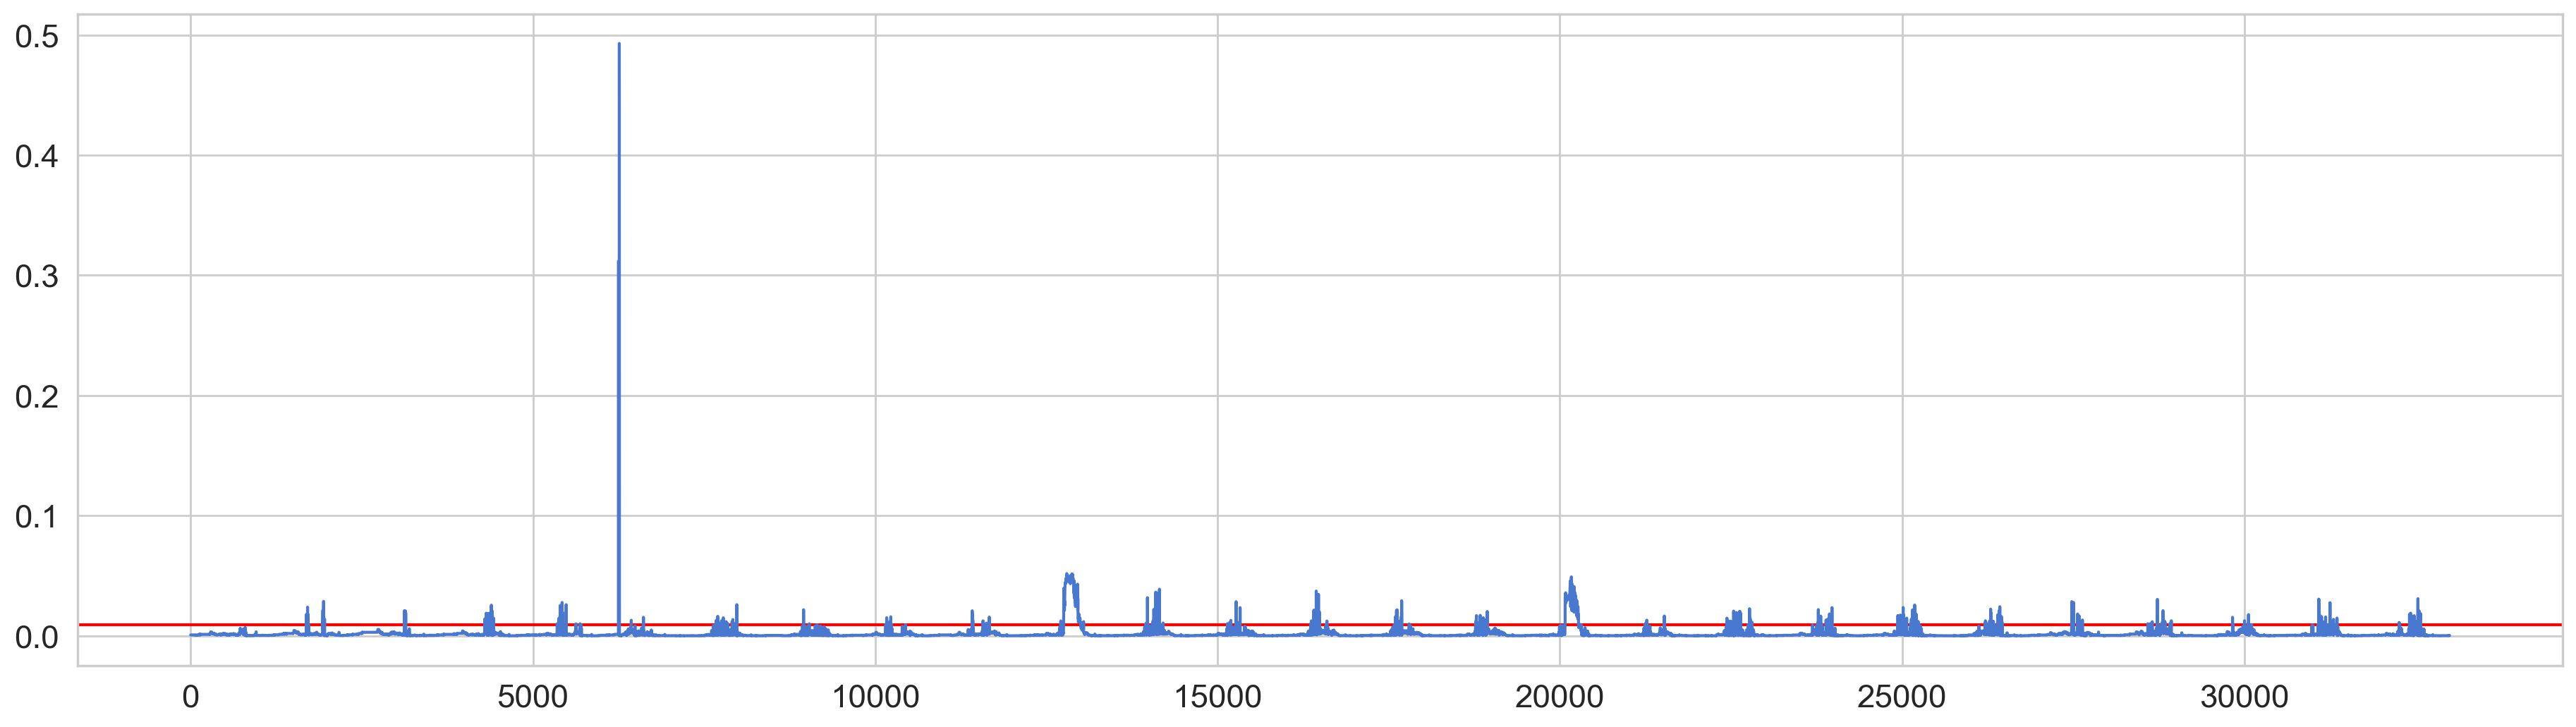

In [18]:
full_df = ParserUtils.get_full_dataframe(7, 5, 2021)

min_max_scaler = MinMaxScaler()

full_df.to_csv('main_test_7_5.csv')
main_test_df_clean = full_df.drop('Data', axis=1)
main_test_df_clean = main_test_df_clean.drop('Fecha', axis=1)
main_test_df_clean = main_test_df_clean.drop('Estado', axis=1)

main_test_norm = min_max_scaler.fit_transform(main_test_df_clean.values)

print(main_test_norm.shape)

X_main_test_norm, y_main_test_norm = DataFrameUtils.temporalize(X = main_test_norm, y = np.zeros(len(main_test_norm)), lookback = timesteps)

X_main_test_norm_array = np.array(X_main_test_norm)
X_main_test_norm_reshaped = X_main_test_norm_array.reshape(X_main_test_norm_array.shape[0], timesteps, n_features)


# Data set clean, predict and get error
pred_test = autoencoder(X_main_test_norm_reshaped).numpy()

pred_test_back = DataFrameUtils.detemporalize(pred_test)
X_main_test_norm_reshaped_back = DataFrameUtils.detemporalize(X_main_test_norm_reshaped)

losses = tf.keras.losses.mse(pred_test_back, X_main_test_norm_reshaped_back)
print(losses.shape)

plt.figure(figsize=(50,6))
plt.subplot(1,2,1)
plt.axhline(y=threshold, color='red', linestyle='-')
plt.plot(np.arange(losses.shape[0]), losses)

Save model if has good results

In [19]:
autoencoder.save('lstm_autoencoder1.h5')

(33003, 12)
(9000,)


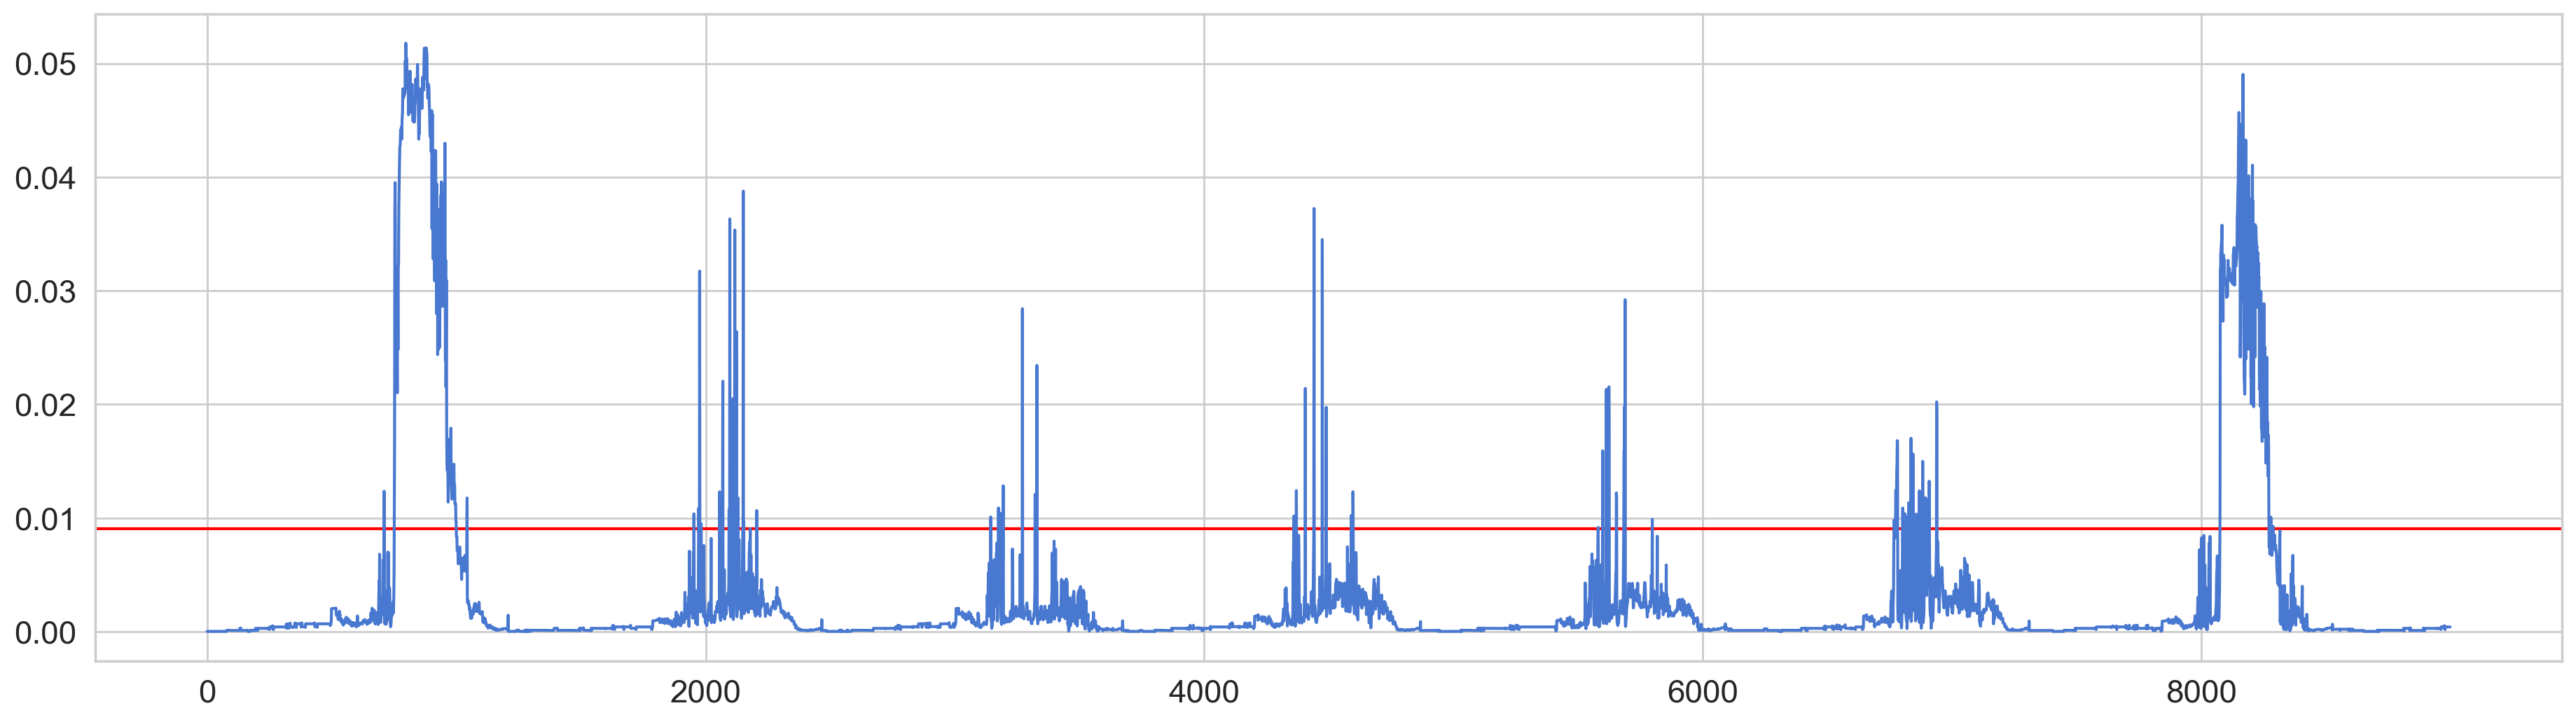

In [20]:
full_df = ParserUtils.get_full_dataframe(7, 5, 2021)

min_max_scaler = MinMaxScaler()

full_df.to_csv('main_test_7_5.csv')
main_test_df_clean = full_df.drop('Data', axis=1)
main_test_df_clean = main_test_df_clean.drop('Fecha', axis=1)
main_test_df_clean = main_test_df_clean.drop('Estado', axis=1)

main_test_norm = min_max_scaler.fit_transform(main_test_df_clean.values)

print(main_test_norm.shape)

X_main_test_norm, y_main_test_norm = DataFrameUtils.temporalize(X = main_test_norm, y = np.zeros(len(main_test_norm)), lookback = timesteps)

X_main_test_norm_array = np.array(X_main_test_norm)
X_main_test_norm_reshaped = X_main_test_norm_array.reshape(X_main_test_norm_array.shape[0], timesteps, n_features)


# Data set clean, predict and get error
pred_test = autoencoder(X_main_test_norm_reshaped).numpy()

pred_test_back = DataFrameUtils.detemporalize(pred_test)
X_main_test_norm_reshaped_back = DataFrameUtils.detemporalize(X_main_test_norm_reshaped)

losses = tf.keras.losses.mse(pred_test_back, X_main_test_norm_reshaped_back)
losses = losses[12000 : 21000]
print(losses.shape)

plt.figure(figsize=(50,6))
plt.subplot(1,2,1)
plt.axhline(y=threshold, color='red', linestyle='-')
plt.plot(np.arange(losses.shape[0]), losses)

(33066, 12)
(1500,)


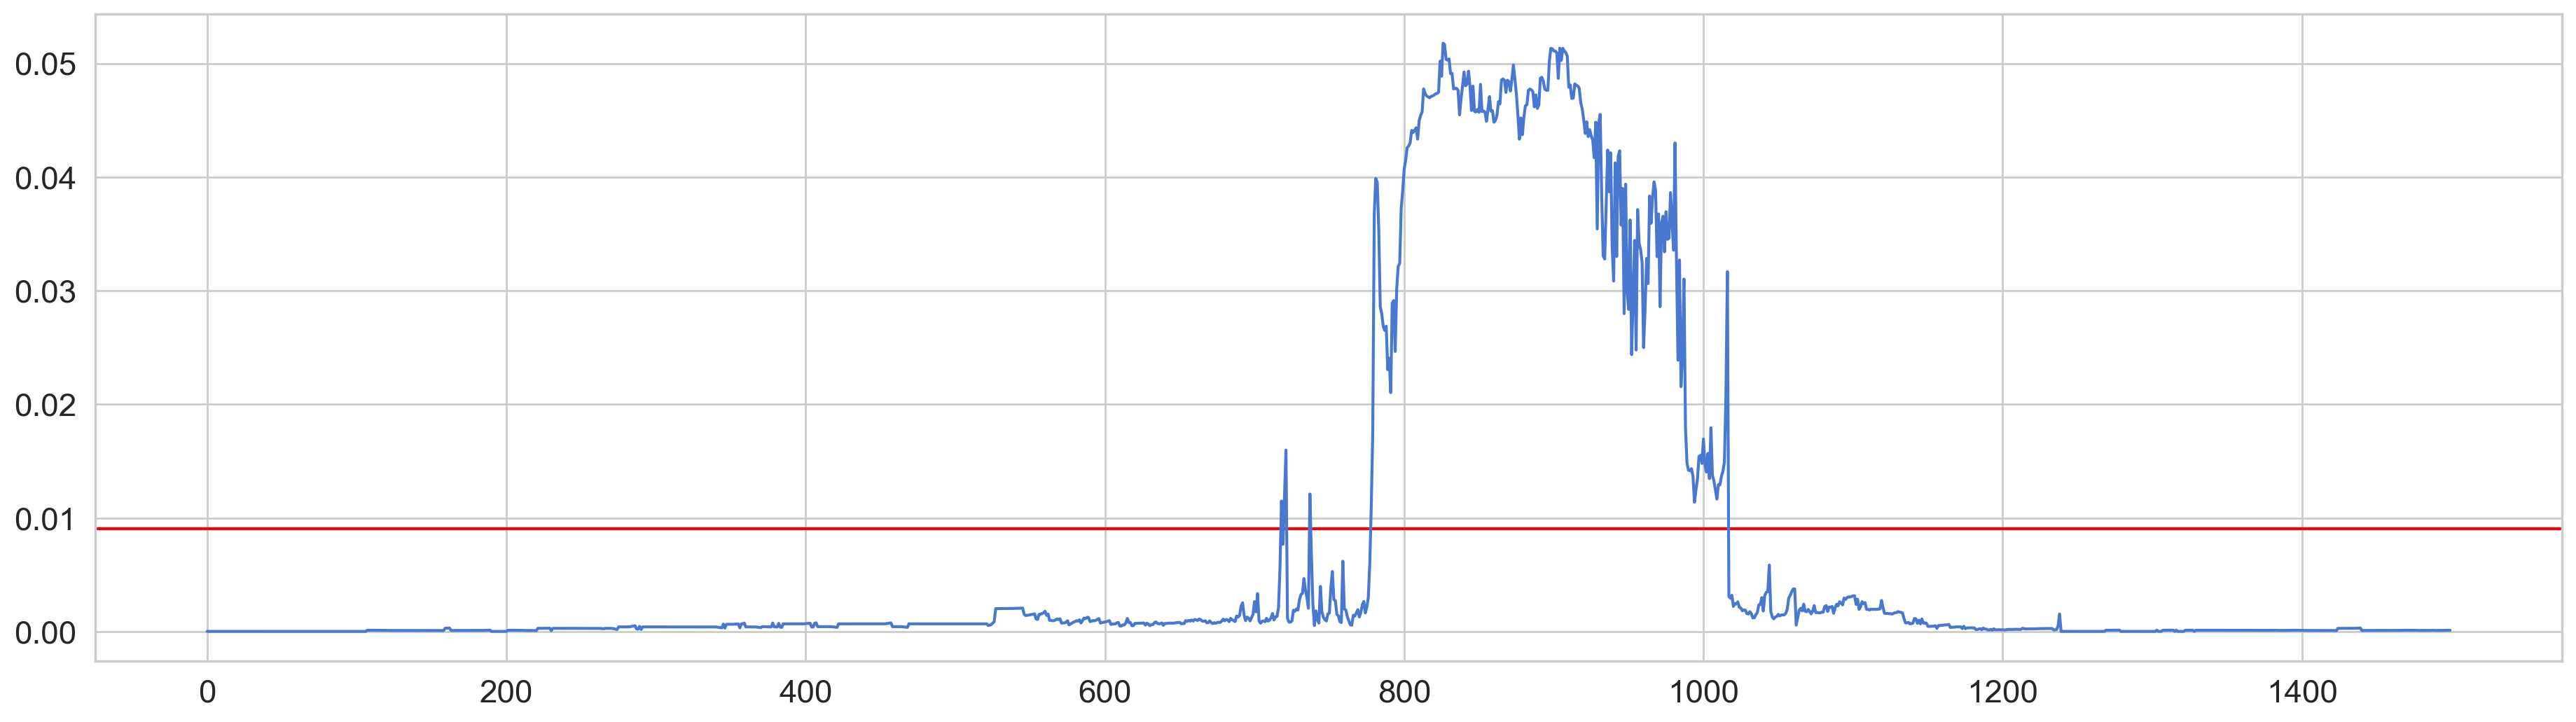

In [21]:
full_df = ParserUtils.get_full_dataframe(1, 5, 2021)

min_max_scaler = MinMaxScaler()

full_df.to_csv('main_test_1_5.csv')
main_test_df_clean = full_df.drop('Data', axis=1)
main_test_df_clean = main_test_df_clean.drop('Fecha', axis=1)
main_test_df_clean = main_test_df_clean.drop('Estado', axis=1)

main_test_norm = min_max_scaler.fit_transform(main_test_df_clean.values)

print(main_test_norm.shape)

X_main_test_norm, y_main_test_norm = DataFrameUtils.temporalize(X = main_test_norm, y = np.zeros(len(main_test_norm)), lookback = timesteps)

X_main_test_norm_array = np.array(X_main_test_norm)
X_main_test_norm_reshaped = X_main_test_norm_array.reshape(X_main_test_norm_array.shape[0], timesteps, n_features)


# Data set clean, predict and get error
pred_test = autoencoder(X_main_test_norm_reshaped).numpy()

pred_test_back = DataFrameUtils.detemporalize(pred_test)
X_main_test_norm_reshaped_back = DataFrameUtils.detemporalize(X_main_test_norm_reshaped)

losses = tf.keras.losses.mse(pred_test_back, X_main_test_norm_reshaped_back)
losses = losses[12000 : 13500]
print(losses.shape)

plt.figure(figsize=(50,6))
plt.subplot(1,2,1)
plt.axhline(y=threshold, color='red', linestyle='-')
plt.plot(np.arange(losses.shape[0]), losses)

(33066, 12)
(6500,)


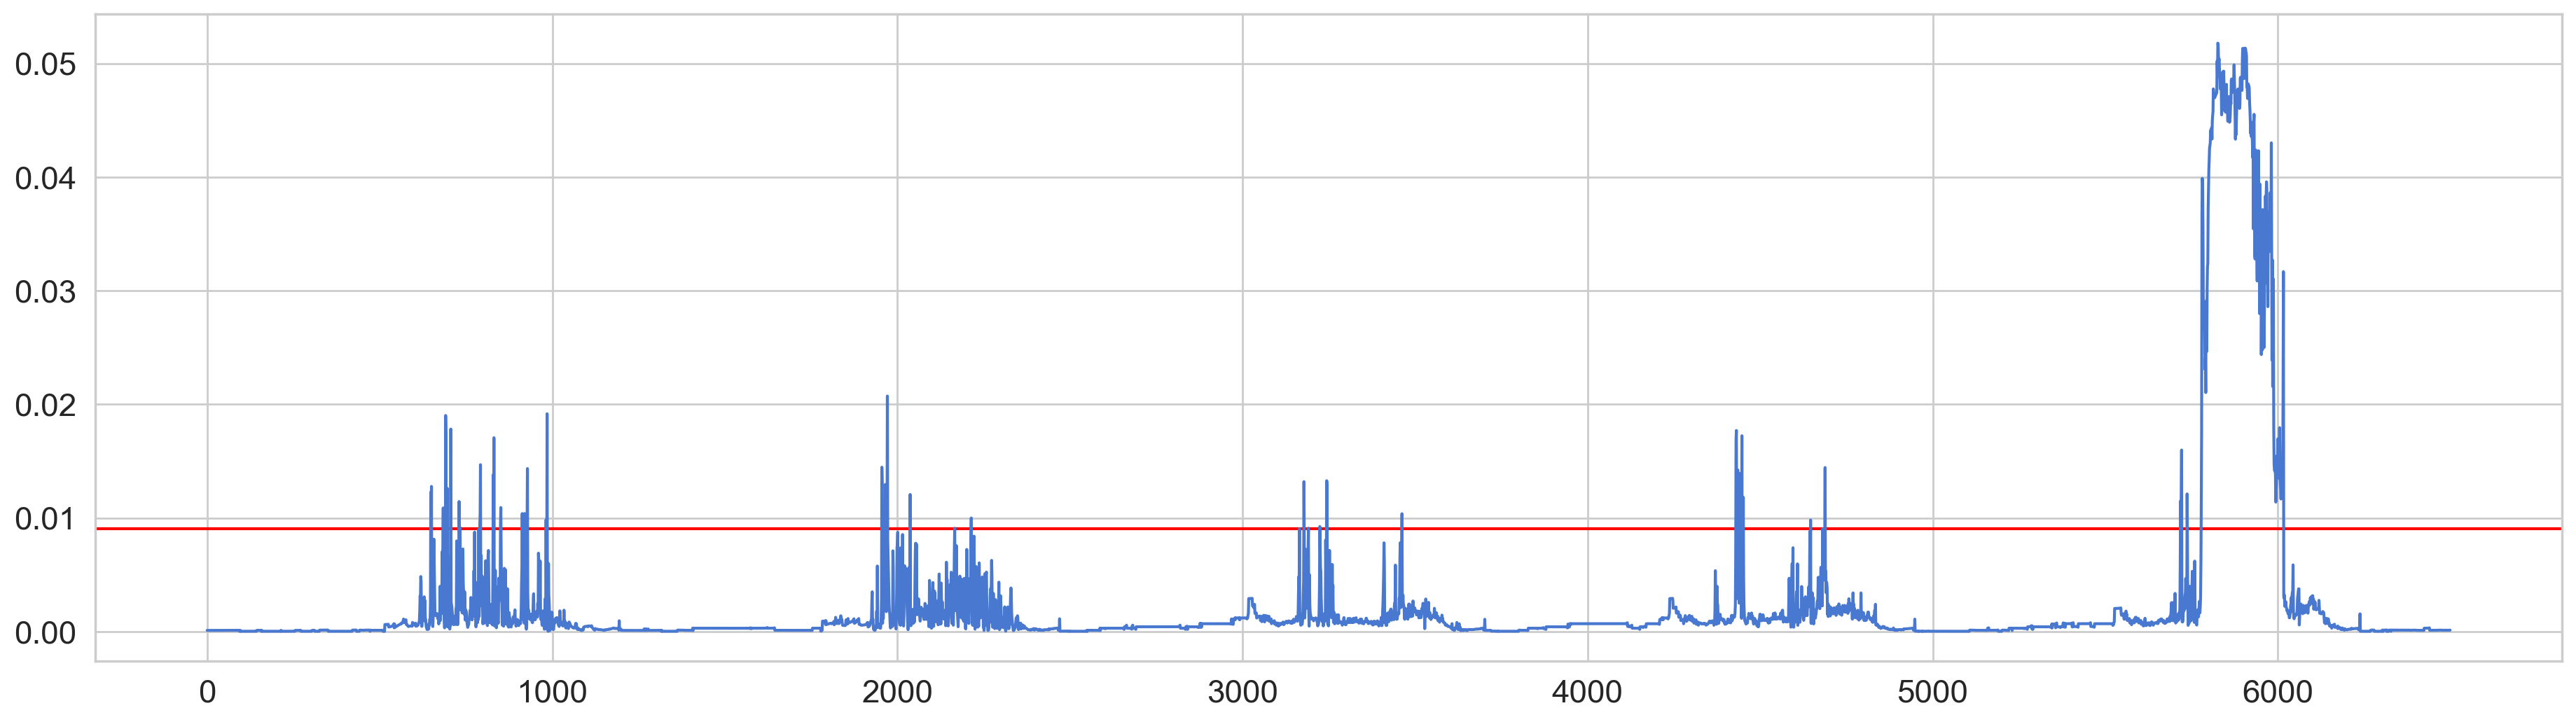

In [22]:
full_df = ParserUtils.get_full_dataframe(1, 5, 2021)

min_max_scaler = MinMaxScaler()

full_df.to_csv('main_test_1_5.csv')
main_test_df_clean = full_df.drop('Data', axis=1)
main_test_df_clean = main_test_df_clean.drop('Fecha', axis=1)
main_test_df_clean = main_test_df_clean.drop('Estado', axis=1)

main_test_norm = min_max_scaler.fit_transform(main_test_df_clean.values)

print(main_test_norm.shape)

X_main_test_norm, y_main_test_norm = DataFrameUtils.temporalize(X = main_test_norm, y = np.zeros(len(main_test_norm)), lookback = timesteps)

X_main_test_norm_array = np.array(X_main_test_norm)
X_main_test_norm_reshaped = X_main_test_norm_array.reshape(X_main_test_norm_array.shape[0], timesteps, n_features)


# Data set clean, predict and get error
pred_test = autoencoder(X_main_test_norm_reshaped).numpy()

pred_test_back = DataFrameUtils.detemporalize(pred_test)
X_main_test_norm_reshaped_back = DataFrameUtils.detemporalize(X_main_test_norm_reshaped)

losses = tf.keras.losses.mse(pred_test_back, X_main_test_norm_reshaped_back)
losses = losses[7000 : 13500]
print(losses.shape)

plt.figure(figsize=(50,6))
plt.subplot(1,2,1)
plt.axhline(y=threshold, color='red', linestyle='-')
plt.plot(np.arange(losses.shape[0]), losses)

(33066, 12)
(1500,)


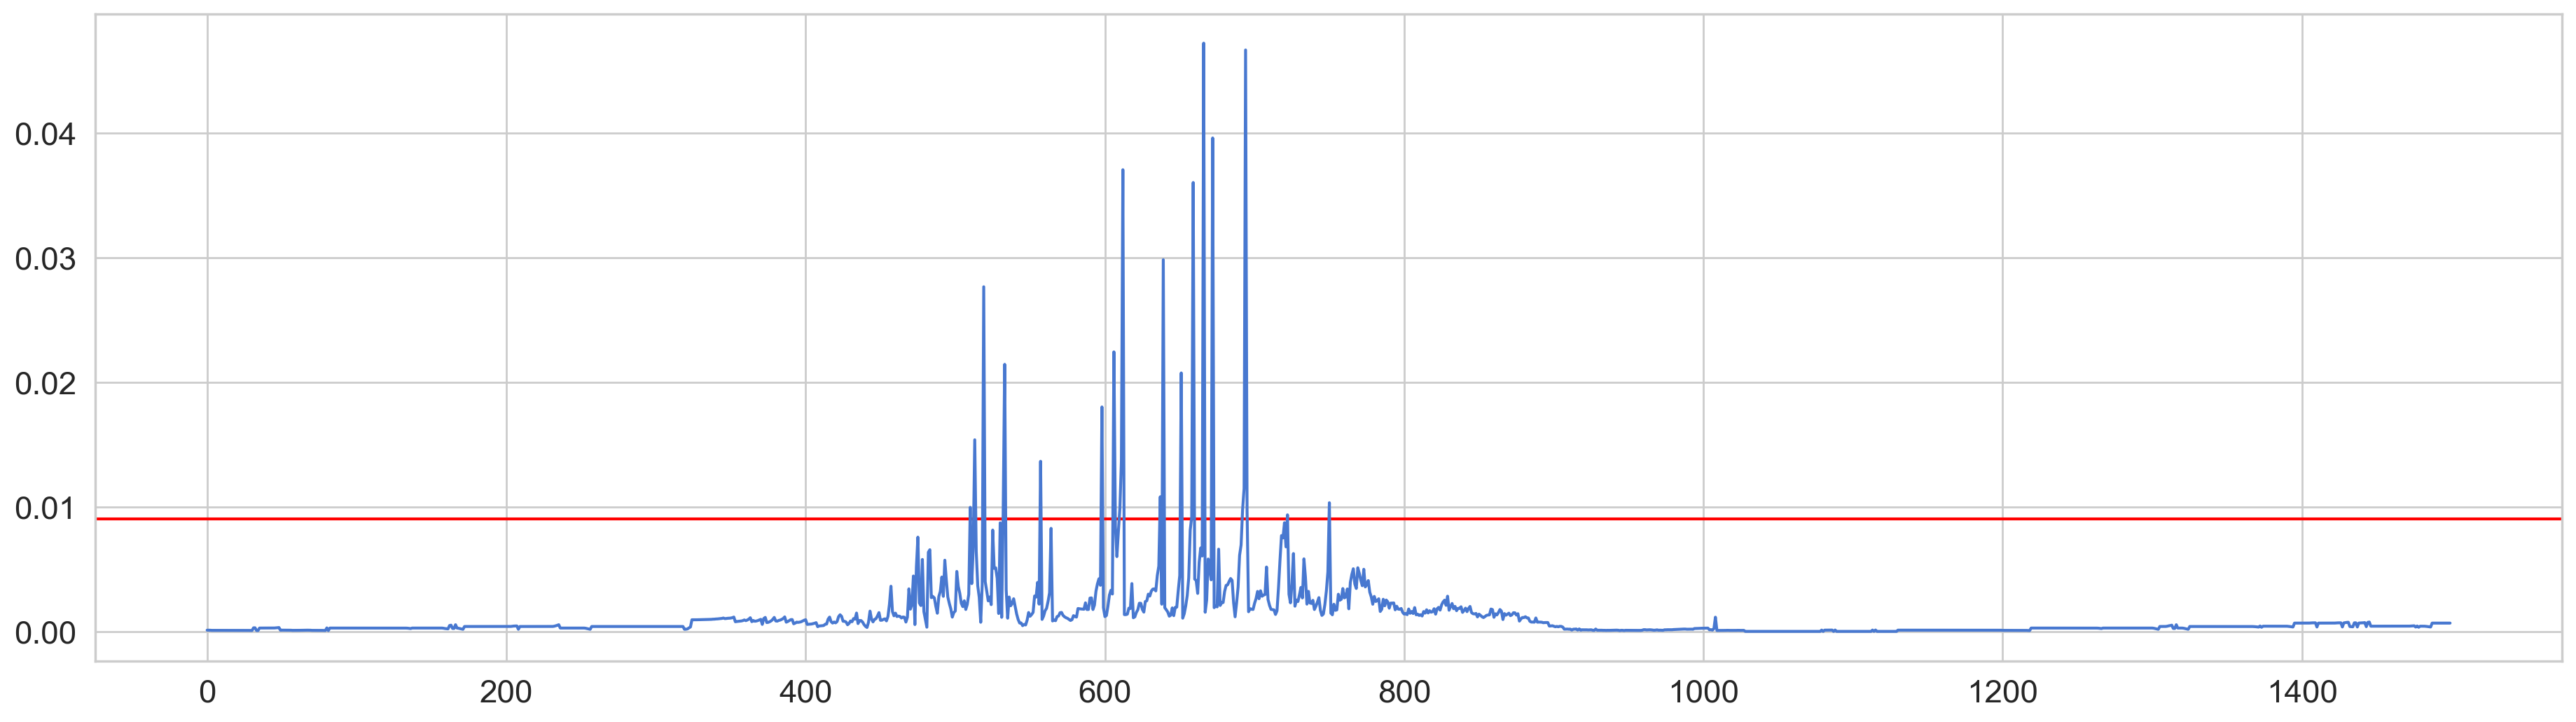

In [23]:
full_df = ParserUtils.get_full_dataframe(1, 5, 2021)

min_max_scaler = MinMaxScaler()

full_df.to_csv('main_test_1_5.csv')
main_test_df_clean = full_df.drop('Data', axis=1)
main_test_df_clean = main_test_df_clean.drop('Fecha', axis=1)
main_test_df_clean = main_test_df_clean.drop('Estado', axis=1)

main_test_norm = min_max_scaler.fit_transform(main_test_df_clean.values)

print(main_test_norm.shape)

X_main_test_norm, y_main_test_norm = DataFrameUtils.temporalize(X = main_test_norm, y = np.zeros(len(main_test_norm)), lookback = timesteps)

X_main_test_norm_array = np.array(X_main_test_norm)
X_main_test_norm_reshaped = X_main_test_norm_array.reshape(X_main_test_norm_array.shape[0], timesteps, n_features)


# Data set clean, predict and get error
pred_test = autoencoder(X_main_test_norm_reshaped).numpy()

pred_test_back = DataFrameUtils.detemporalize(pred_test)
X_main_test_norm_reshaped_back = DataFrameUtils.detemporalize(X_main_test_norm_reshaped)

losses = tf.keras.losses.mse(pred_test_back, X_main_test_norm_reshaped_back)
losses = losses[13500 : 15000]
print(losses.shape)

plt.figure(figsize=(50,6))
plt.subplot(1,2,1)
plt.axhline(y=threshold, color='red', linestyle='-')
plt.plot(np.arange(losses.shape[0]), losses)